# Evaluation

In this notebook, a trained RetinaNet model is loaded and evaluated.

## Testing

In [37]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import keras
import keras.preprocessing.image
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.preprocessing.csv_generator import CSVGenerator

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
with (open("history_30_5000.pkl", "rb")) as history_file:
    history = pickle.load(history_file)

dict_keys(['val_loss', 'val_regression_loss', 'val_classification_loss', 'loss', 'regression_loss', 'classification_loss', 'lr'])


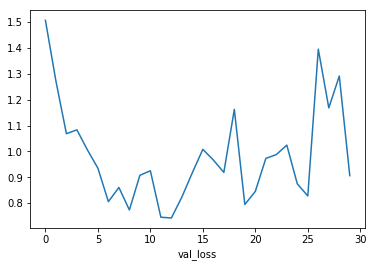

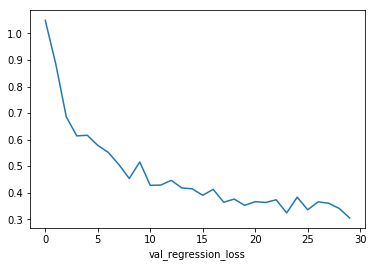

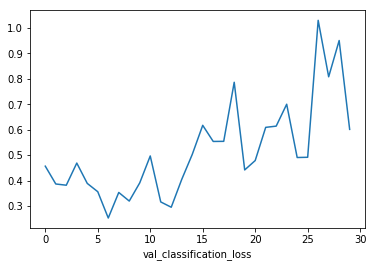

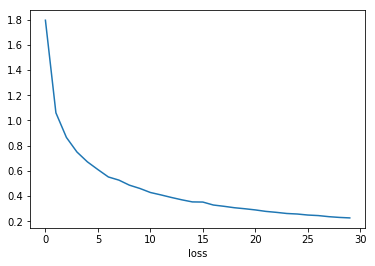

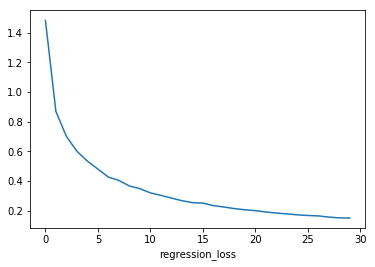

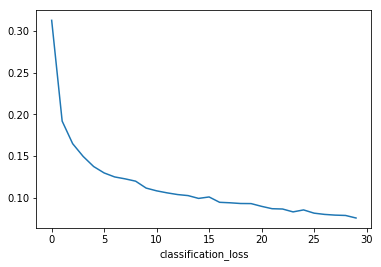

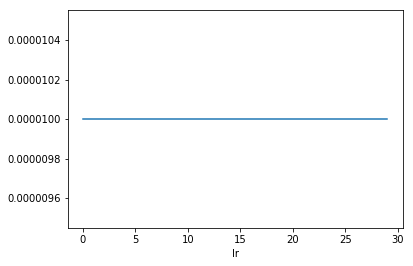

In [39]:
print(history.keys())

for key in history.keys():
    plt.plot(history[key])
    plt.xlabel(key)
    plt.savefig('{}.png'.format(key))
    plt.show()

In [50]:
model = keras.models.load_model('./snapshots/e30s5000/resnet50_csv_30.h5', custom_objects=custom_objects)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        padding_conv1[0][0]              
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu

/home/appsyoon/miniconda3/envs/capstone/lib/python3.6/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [51]:
# create image data generator object
test_generator = keras.preprocessing.image.ImageDataGenerator()

# create a generator for testing data
csv_test_generator = CSVGenerator(
    './data/test.csv',
    './data/classes.csv',
    test_generator,
    batch_size=1,
)
index = 14

processing time:  4.4033379554748535


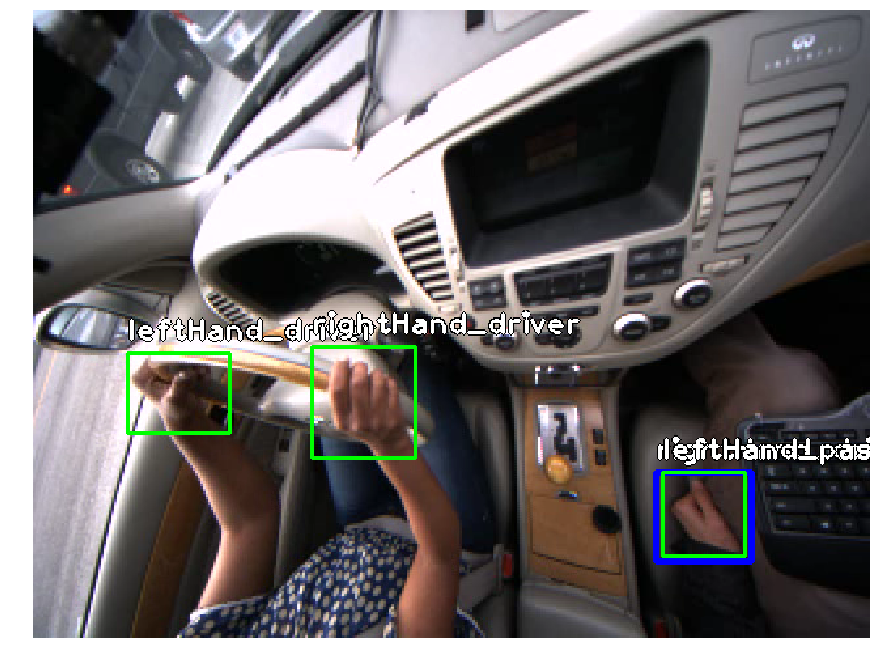

In [52]:
# load image
image = csv_test_generator.load_image(index)

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = csv_test_generator.preprocess_image(image)
image, scale = csv_test_generator.resize_image(image)
annotations = csv_test_generator.load_annotations(index)

# process image
start = time.time()
_, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# compute predicted labels and scores
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

# correct for image scale
detections[0, :, :4] /= scale

# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.25:
        continue
    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
    caption = "{} {:.3f}".format(csv_test_generator.label_to_name(label), score)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
# visualize annotations
for annotation in annotations:
    label = int(annotation[4])
    b = annotation[:4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)
    caption = "{}".format(csv_test_generator.label_to_name(label))
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

In [41]:
print(detections[0,100,:])

[  2.38607941e+02   3.05270447e+02   2.77814270e+02   3.41125610e+02
   2.98094191e-02   3.22322026e-02   2.81520877e-02   2.70711984e-02]


In [9]:
image_path = csv_test_generator.image_path(1)

10L_0015701_Q_1_4_5


In [53]:
entries = []

for index in range(csv_test_generator.size()):
    # load image
    image = csv_test_generator.load_image(index)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = csv_test_generator.preprocess_image(image)
    image, scale = csv_test_generator.resize_image(image)
    annotations = csv_test_generator.load_annotations(index)

    # process image
    start = time.time()
    _, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # compute predicted labels and scores
    predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
    scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

    # correct for image scale
    detections[0, :, :4] /= scale

    # visualize detections
    for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
        if score < 0.25:
            continue
        _, filename = os.path.split(csv_test_generator.image_path(index))
        filename, _ = os.path.splitext(filename)
        
        b = detections[0, idx, :4].astype(int)
        
        if b[0] < b[2]:
            x, y, w, h = float(b[0]), float(b[1]), float(b[2]-b[0]), float(b[3]-b[1])
        else:
            x, y, w, h = float(b[1]), float(b[0]), float(b[0]-b[2]), float(b[1]-b[3])
            
        entry = '{} {} {} {} {} {} -1 -1 -1'.format(filename, x, y, w, h, score)
        print(entry)
        entries.append(entry)

submission = '\n'.join(entries)
with open('submission.txt', 'w') as file:
    file.write(submission)

processing time:  3.081179141998291
processing time:  3.0874545574188232
processing time:  3.0445306301116943
processing time:  3.0574121475219727
processing time:  3.0303726196289062
processing time:  3.0643556118011475
processing time:  3.0749049186706543
processing time:  3.075477123260498
processing time:  3.043347120285034
processing time:  3.0488853454589844
processing time:  3.035621166229248
10L_0015711_Q_1_4_5 476.0 353.0 73.0 68.0 0.27302423119544983 -1 -1 -1
processing time:  3.059582233428955
10L_0015712_Q_1_4_5 476.0 353.0 73.0 67.0 0.25131863355636597 -1 -1 -1
processing time:  3.0582258701324463
10L_0015714_Q_1_4_5 476.0 353.0 73.0 68.0 0.2835507094860077 -1 -1 -1
processing time:  3.0558598041534424
10L_0015715_Q_1_4_5 476.0 353.0 73.0 68.0 0.2508409321308136 -1 -1 -1
processing time:  3.0523695945739746
10L_0015717_Q_1_4_5 476.0 353.0 73.0 68.0 0.2599794566631317 -1 -1 -1
processing time:  3.031343460083008
processing time:  3.0414769649505615
processing time:  3.03554

processing time:  3.0675175189971924
10L_0015809_Q_1_4_5 476.0 351.0 73.0 70.0 0.33765190839767456 -1 -1 -1
10L_0015809_Q_1_4_5 269.0 288.0 52.0 76.0 0.30038851499557495 -1 -1 -1
processing time:  3.0713019371032715
10L_0015812_Q_1_4_5 277.0 302.0 48.0 57.0 0.5073398351669312 -1 -1 -1
10L_0015812_Q_1_4_5 476.0 351.0 73.0 69.0 0.30304571986198425 -1 -1 -1
processing time:  3.038018226623535
10L_0015813_Q_1_4_5 477.0 351.0 71.0 69.0 0.3139598071575165 -1 -1 -1
10L_0015813_Q_1_4_5 277.0 307.0 44.0 57.0 0.2936133146286011 -1 -1 -1
processing time:  3.0212912559509277
10L_0015814_Q_1_4_5 476.0 351.0 72.0 69.0 0.3067190647125244 -1 -1 -1
10L_0015814_Q_1_4_5 278.0 305.0 43.0 59.0 0.2858741581439972 -1 -1 -1
processing time:  3.039201498031616
10L_0015816_Q_1_4_5 476.0 351.0 71.0 69.0 0.2974441945552826 -1 -1 -1
processing time:  3.022372007369995
processing time:  3.0437967777252197
processing time:  3.040046215057373
10L_0015820_Q_1_4_5 477.0 351.0 71.0 70.0 0.25133103132247925 -1 -1 -1
proc

processing time:  3.025123357772827
10L_0015898_Q_1_4_5 365.0 316.0 54.0 83.0 0.2980194091796875 -1 -1 -1
10L_0015898_Q_1_4_5 477.0 353.0 71.0 67.0 0.26085782051086426 -1 -1 -1
processing time:  3.041177988052368
10L_0015900_Q_1_4_5 366.0 313.0 56.0 86.0 0.27450910210609436 -1 -1 -1
10L_0015900_Q_1_4_5 477.0 352.0 73.0 69.0 0.2567408084869385 -1 -1 -1
processing time:  3.0406198501586914
10L_0015901_Q_1_4_5 367.0 314.0 56.0 84.0 0.40895381569862366 -1 -1 -1
10L_0015901_Q_1_4_5 476.0 353.0 74.0 69.0 0.2616613507270813 -1 -1 -1
processing time:  3.05997633934021
10L_0015902_Q_1_4_5 368.0 314.0 53.0 83.0 0.4075891971588135 -1 -1 -1
10L_0015902_Q_1_4_5 476.0 352.0 74.0 70.0 0.2533845007419586 -1 -1 -1
processing time:  3.0631484985351562
10L_0015903_Q_1_4_5 367.0 313.0 54.0 85.0 0.46207869052886963 -1 -1 -1
processing time:  3.04986572265625
10L_0015904_Q_1_4_5 370.0 316.0 50.0 77.0 0.3575986921787262 -1 -1 -1
processing time:  3.0555918216705322
10L_0015905_Q_1_4_5 367.0 313.0 53.0 83.0 0

processing time:  3.0554440021514893
10L_0016062_Q_1_4_5 330.0 215.0 91.0 112.0 0.2626829743385315 -1 -1 -1
processing time:  3.0745434761047363
10L_0016064_Q_1_4_5 342.0 209.0 88.0 114.0 0.37780123949050903 -1 -1 -1
processing time:  3.034052848815918
10L_0016065_Q_1_4_5 344.0 207.0 88.0 114.0 0.32505035400390625 -1 -1 -1
processing time:  3.027383804321289
10L_0016066_Q_1_4_5 340.0 208.0 90.0 117.0 0.30326318740844727 -1 -1 -1
processing time:  3.042743682861328
10L_0016067_Q_1_4_5 340.0 207.0 89.0 118.0 0.3614281117916107 -1 -1 -1
processing time:  3.0132546424865723
10L_0016068_Q_1_4_5 340.0 208.0 90.0 117.0 0.38378146290779114 -1 -1 -1
processing time:  3.0267984867095947
10L_0016069_Q_1_4_5 341.0 208.0 90.0 115.0 0.3983248472213745 -1 -1 -1
processing time:  3.0379247665405273
10L_0016070_Q_1_4_5 341.0 207.0 90.0 117.0 0.4375779926776886 -1 -1 -1
processing time:  3.028395652770996
10L_0016071_Q_1_4_5 342.0 208.0 90.0 117.0 0.459513783454895 -1 -1 -1
processing time:  3.017171621

processing time:  3.0411343574523926
processing time:  3.057859420776367
10L_0016180_Q_1_4_5 312.0 210.0 86.0 120.0 0.30174383521080017 -1 -1 -1
processing time:  3.0437943935394287
10L_0016181_Q_1_4_5 270.0 218.0 82.0 117.0 0.7151826620101929 -1 -1 -1
processing time:  3.0315942764282227
10L_0016183_Q_1_4_5 225.0 232.0 84.0 109.0 0.3840923011302948 -1 -1 -1
processing time:  3.086768627166748
processing time:  3.0656940937042236
processing time:  3.0392837524414062
processing time:  3.064300298690796
processing time:  3.047173261642456
processing time:  3.0846946239471436
processing time:  3.0643818378448486
processing time:  3.0335843563079834
processing time:  3.048295021057129
processing time:  3.012723445892334
processing time:  3.0267562866210938
processing time:  3.0702309608459473
processing time:  3.0612576007843018
processing time:  3.1280105113983154
processing time:  3.1454694271087646
processing time:  3.246384859085083
processing time:  3.09576416015625
processing time:  

processing time:  3.772040605545044
14_0000205_0_0_0_3 980.0 896.0 211.0 194.0 0.3454599678516388 -1 -1 -1
processing time:  3.7480218410491943
14_0000206_0_0_0_3 978.0 895.0 212.0 196.0 0.36573028564453125 -1 -1 -1
processing time:  3.7740252017974854
14_0000207_0_0_0_3 977.0 891.0 211.0 201.0 0.2980128526687622 -1 -1 -1
14_0000207_0_0_0_3 110.0 92.0 392.0 226.0 0.26685643196105957 -1 -1 -1
processing time:  3.700570821762085
14_0000208_0_0_0_3 103.0 92.0 393.0 227.0 0.2587778866291046 -1 -1 -1
processing time:  3.7235212326049805
14_0000209_0_0_0_3 85.0 90.0 398.0 237.0 0.29428529739379883 -1 -1 -1
processing time:  3.7561960220336914
14_0000210_0_0_0_3 86.0 90.0 399.0 237.0 0.2817193269729614 -1 -1 -1
processing time:  3.780319929122925
14_0000211_0_0_0_3 83.0 89.0 399.0 238.0 0.26707327365875244 -1 -1 -1
processing time:  3.7265400886535645
14_0000212_0_0_0_3 942.0 898.0 261.0 199.0 0.3443552851676941 -1 -1 -1
14_0000212_0_0_0_3 83.0 91.0 404.0 238.0 0.25497323274612427 -1 -1 -1
pr

processing time:  3.740218162536621
14_0000332_0_0_0_3 935.0 926.0 244.0 159.0 0.4724544286727905 -1 -1 -1
14_0000332_0_0_0_3 54.0 95.0 375.0 233.0 0.30219221115112305 -1 -1 -1
processing time:  3.7703795433044434
14_0000333_0_0_0_3 965.0 921.0 252.0 163.0 0.46767136454582214 -1 -1 -1
14_0000333_0_0_0_3 55.0 97.0 376.0 229.0 0.3322886526584625 -1 -1 -1
processing time:  3.7755255699157715
14_0000334_0_0_0_3 972.0 918.0 265.0 168.0 0.48695409297943115 -1 -1 -1
14_0000334_0_0_0_3 53.0 97.0 377.0 229.0 0.2829224169254303 -1 -1 -1
processing time:  3.726155996322632
14_0000335_0_0_0_3 948.0 908.0 283.0 180.0 0.4812038242816925 -1 -1 -1
14_0000335_0_0_0_3 49.0 98.0 383.0 228.0 0.3048207759857178 -1 -1 -1
processing time:  3.7299017906188965
14_0000336_0_0_0_3 869.0 907.0 294.0 187.0 0.3941797912120819 -1 -1 -1
14_0000336_0_0_0_3 54.0 97.0 377.0 223.0 0.2771996557712555 -1 -1 -1
processing time:  3.7214953899383545
14_0000337_0_0_0_3 870.0 907.0 293.0 187.0 0.3899349868297577 -1 -1 -1
14_000

processing time:  3.766674041748047
14_0001761_0_0_0_3 916.0 576.0 249.0 274.0 0.5415914058685303 -1 -1 -1
processing time:  3.74399471282959
14_0001762_0_0_0_3 914.0 572.0 249.0 276.0 0.528782844543457 -1 -1 -1
processing time:  3.7054789066314697
14_0001763_0_0_0_3 908.0 573.0 247.0 284.0 0.49555322527885437 -1 -1 -1
processing time:  3.734626293182373
14_0001764_0_0_0_3 903.0 576.0 243.0 288.0 0.4829607605934143 -1 -1 -1
processing time:  3.719257354736328
14_0001765_0_0_0_3 888.0 577.0 246.0 282.0 0.5807409286499023 -1 -1 -1
processing time:  3.7028400897979736
14_0001766_0_0_0_3 874.0 585.0 255.0 284.0 0.34753063321113586 -1 -1 -1
processing time:  3.696990966796875
14_0001769_0_0_0_3 791.0 598.0 272.0 270.0 0.45787304639816284 -1 -1 -1
processing time:  3.7324092388153076
14_0001770_0_0_0_3 776.0 596.0 270.0 276.0 0.6508227586746216 -1 -1 -1
processing time:  3.7156076431274414
14_0001771_0_0_0_3 756.0 595.0 272.0 277.0 0.5895460844039917 -1 -1 -1
processing time:  3.752127647399

processing time:  3.7178778648376465
19_0002082_0_0_0_6 384.0 518.0 132.0 158.0 0.4970890283584595 -1 -1 -1
processing time:  3.7340610027313232
19_0002083_0_0_0_6 378.0 512.0 139.0 161.0 0.5584917068481445 -1 -1 -1
processing time:  3.701517105102539
19_0002084_0_0_0_6 367.0 504.0 141.0 160.0 0.6221444010734558 -1 -1 -1
processing time:  3.696012258529663
19_0002086_0_0_0_6 356.0 482.0 146.0 167.0 0.3439783453941345 -1 -1 -1
processing time:  3.6993367671966553
19_0002087_0_0_0_6 353.0 494.0 146.0 171.0 0.5577581524848938 -1 -1 -1
processing time:  3.7259199619293213
19_0002088_0_0_0_6 359.0 517.0 144.0 163.0 0.47098255157470703 -1 -1 -1
processing time:  3.735369920730591
19_0002090_0_0_0_6 359.0 534.0 144.0 167.0 0.6396822929382324 -1 -1 -1
processing time:  3.7037150859832764
19_0002093_0_0_0_6 367.0 515.0 134.0 163.0 0.5869388580322266 -1 -1 -1
processing time:  3.7090981006622314
19_0002095_0_0_0_6 366.0 517.0 132.0 160.0 0.4634997844696045 -1 -1 -1
processing time:  3.7447721958

processing time:  3.0363986492156982
1L_0012917_Q_6_2_5 485.0 356.0 93.0 72.0 0.4648163616657257 -1 -1 -1
1L_0012917_Q_6_2_5 49.0 301.0 79.0 58.0 0.4399603605270386 -1 -1 -1
1L_0012917_Q_6_2_5 154.0 268.0 136.0 91.0 0.41732457280158997 -1 -1 -1
1L_0012917_Q_6_2_5 563.0 317.0 71.0 67.0 0.3514992892742157 -1 -1 -1
processing time:  3.032332420349121
1L_0012918_Q_6_2_5 485.0 356.0 93.0 72.0 0.45869120955467224 -1 -1 -1
1L_0012918_Q_6_2_5 50.0 301.0 79.0 57.0 0.4421469271183014 -1 -1 -1
1L_0012918_Q_6_2_5 152.0 268.0 137.0 91.0 0.4145994186401367 -1 -1 -1
1L_0012918_Q_6_2_5 563.0 317.0 71.0 68.0 0.3409416973590851 -1 -1 -1
processing time:  3.087934970855713
1L_0012919_Q_6_2_5 485.0 356.0 93.0 72.0 0.4563802182674408 -1 -1 -1
1L_0012919_Q_6_2_5 52.0 302.0 77.0 57.0 0.43362727761268616 -1 -1 -1
1L_0012919_Q_6_2_5 151.0 268.0 137.0 90.0 0.4157298505306244 -1 -1 -1
1L_0012919_Q_6_2_5 564.0 317.0 70.0 67.0 0.35821732878685 -1 -1 -1
processing time:  3.0409586429595947
1L_0012920_Q_6_2_5 485.0 

processing time:  3.06345272064209
1L_0012950_Q_6_2_5 87.0 309.0 70.0 51.0 0.606232762336731 -1 -1 -1
1L_0012950_Q_6_2_5 84.0 252.0 169.0 101.0 0.48597630858421326 -1 -1 -1
1L_0012950_Q_6_2_5 486.0 356.0 93.0 72.0 0.454386830329895 -1 -1 -1
1L_0012950_Q_6_2_5 566.0 317.0 66.0 67.0 0.4146907329559326 -1 -1 -1
processing time:  3.0342836380004883
1L_0012998_Q_6_2_5 204.0 278.0 89.0 80.0 0.49877265095710754 -1 -1 -1
1L_0012998_Q_6_2_5 483.0 356.0 94.0 72.0 0.46244001388549805 -1 -1 -1
1L_0012998_Q_6_2_5 125.0 319.0 71.0 47.0 0.4622921943664551 -1 -1 -1
1L_0012998_Q_6_2_5 564.0 318.0 67.0 67.0 0.3748777508735657 -1 -1 -1
processing time:  3.0334343910217285
1L_0012999_Q_6_2_5 484.0 356.0 93.0 72.0 0.4717658758163452 -1 -1 -1
1L_0012999_Q_6_2_5 208.0 280.0 90.0 78.0 0.4248476028442383 -1 -1 -1
1L_0012999_Q_6_2_5 129.0 320.0 73.0 46.0 0.3880414068698883 -1 -1 -1
1L_0012999_Q_6_2_5 563.0 318.0 68.0 67.0 0.34935590624809265 -1 -1 -1
processing time:  3.0533783435821533
1L_0013000_Q_6_2_5 216.0

processing time:  3.062252998352051
1L_0013033_Q_6_2_5 133.0 264.0 140.0 98.0 0.5032280087471008 -1 -1 -1
1L_0013033_Q_6_2_5 473.0 356.0 91.0 72.0 0.4685424566268921 -1 -1 -1
1L_0013033_Q_6_2_5 259.0 310.0 40.0 56.0 0.3959234356880188 -1 -1 -1
1L_0013033_Q_6_2_5 548.0 320.0 77.0 69.0 0.3826849162578583 -1 -1 -1
processing time:  3.040078639984131
1L_0013034_Q_6_2_5 155.0 268.0 128.0 96.0 0.4924577474594116 -1 -1 -1
1L_0013034_Q_6_2_5 475.0 356.0 92.0 73.0 0.4302828311920166 -1 -1 -1
1L_0013034_Q_6_2_5 549.0 320.0 77.0 69.0 0.3807404041290283 -1 -1 -1
processing time:  3.0707409381866455
1L_0013035_Q_6_2_5 163.0 270.0 128.0 94.0 0.46973997354507446 -1 -1 -1
1L_0013035_Q_6_2_5 478.0 357.0 89.0 71.0 0.38407281041145325 -1 -1 -1
1L_0013035_Q_6_2_5 549.0 320.0 77.0 69.0 0.3831464350223541 -1 -1 -1
processing time:  3.058480978012085
1L_0013036_Q_6_2_5 167.0 270.0 127.0 94.0 0.496473103761673 -1 -1 -1
1L_0013036_Q_6_2_5 550.0 321.0 77.0 68.0 0.3687390685081482 -1 -1 -1
1L_0013036_Q_6_2_5 478

processing time:  3.025536298751831
1L_0013072_Q_6_2_5 245.0 292.0 66.0 69.0 0.5249080657958984 -1 -1 -1
1L_0013072_Q_6_2_5 479.0 355.0 89.0 70.0 0.42816346883773804 -1 -1 -1
1L_0013072_Q_6_2_5 548.0 322.0 81.0 70.0 0.39220598340034485 -1 -1 -1
processing time:  3.047159433364868
1L_0013073_Q_6_2_5 241.0 290.0 70.0 72.0 0.6073242425918579 -1 -1 -1
1L_0013073_Q_6_2_5 479.0 355.0 88.0 70.0 0.420526385307312 -1 -1 -1
1L_0013073_Q_6_2_5 548.0 322.0 80.0 69.0 0.4100678861141205 -1 -1 -1
processing time:  3.014627695083618
1L_0013074_Q_6_2_5 226.0 283.0 85.0 77.0 0.5321048498153687 -1 -1 -1
1L_0013074_Q_6_2_5 479.0 355.0 88.0 70.0 0.43455561995506287 -1 -1 -1
1L_0013074_Q_6_2_5 548.0 322.0 80.0 69.0 0.4117354452610016 -1 -1 -1
processing time:  3.0310957431793213
1L_0013075_Q_6_2_5 221.0 280.0 87.0 82.0 0.6638580560684204 -1 -1 -1
1L_0013075_Q_6_2_5 479.0 355.0 88.0 70.0 0.44022953510284424 -1 -1 -1
1L_0013075_Q_6_2_5 548.0 322.0 80.0 69.0 0.41351625323295593 -1 -1 -1
processing time:  3.040

processing time:  3.0446786880493164
1L_0013126_Q_6_2_5 554.0 322.0 77.0 69.0 0.4326719343662262 -1 -1 -1
1L_0013126_Q_6_2_5 27.0 300.0 86.0 55.0 0.30068981647491455 -1 -1 -1
1L_0013126_Q_6_2_5 237.0 274.0 73.0 81.0 0.28711238503456116 -1 -1 -1
processing time:  3.0481464862823486
1L_0013128_Q_6_2_5 553.0 322.0 77.0 69.0 0.4218637943267822 -1 -1 -1
1L_0013128_Q_6_2_5 27.0 301.0 86.0 53.0 0.25860875844955444 -1 -1 -1
processing time:  3.080010414123535
1L_0013129_Q_6_2_5 554.0 322.0 75.0 69.0 0.43923816084861755 -1 -1 -1
1L_0013129_Q_6_2_5 231.0 272.0 77.0 86.0 0.43681102991104126 -1 -1 -1
1L_0013129_Q_6_2_5 32.0 302.0 86.0 51.0 0.27295902371406555 -1 -1 -1
processing time:  3.061751365661621
1L_0013131_Q_6_2_5 228.0 271.0 79.0 83.0 0.5267435908317566 -1 -1 -1
1L_0013131_Q_6_2_5 554.0 322.0 75.0 69.0 0.453755259513855 -1 -1 -1
1L_0013131_Q_6_2_5 29.0 300.0 87.0 55.0 0.3381197154521942 -1 -1 -1
processing time:  3.0420236587524414
1L_0013133_Q_6_2_5 228.0 271.0 78.0 85.0 0.49930015206336

processing time:  3.0525636672973633
1L_0013174_Q_6_2_5 558.0 321.0 74.0 68.0 0.3976566195487976 -1 -1 -1
1L_0013174_Q_6_2_5 75.0 310.0 86.0 48.0 0.33237749338150024 -1 -1 -1
processing time:  3.036625862121582
1L_0013175_Q_6_2_5 559.0 321.0 74.0 68.0 0.391550213098526 -1 -1 -1
1L_0013175_Q_6_2_5 76.0 310.0 85.0 48.0 0.34550362825393677 -1 -1 -1
processing time:  3.0546462535858154
1L_0013176_Q_6_2_5 557.0 321.0 74.0 68.0 0.3940955102443695 -1 -1 -1
1L_0013176_Q_6_2_5 79.0 311.0 84.0 47.0 0.3542424142360687 -1 -1 -1
1L_0013176_Q_6_2_5 257.0 279.0 61.0 82.0 0.2561006546020508 -1 -1 -1
processing time:  3.0243780612945557
1L_0013177_Q_6_2_5 558.0 321.0 73.0 68.0 0.3768162429332733 -1 -1 -1
1L_0013177_Q_6_2_5 255.0 276.0 63.0 82.0 0.31346163153648376 -1 -1 -1
1L_0013177_Q_6_2_5 85.0 311.0 80.0 47.0 0.3011346459388733 -1 -1 -1
processing time:  3.067265748977661
1L_0013178_Q_6_2_5 558.0 321.0 73.0 68.0 0.37933966517448425 -1 -1 -1
1L_0013178_Q_6_2_5 84.0 310.0 82.0 49.0 0.3557398021221161 

processing time:  3.0685176849365234
1L_0013215_Q_6_2_5 122.0 316.0 61.0 48.0 0.6433809399604797 -1 -1 -1
1L_0013215_Q_6_2_5 557.0 322.0 75.0 67.0 0.5214176177978516 -1 -1 -1
1L_0013215_Q_6_2_5 468.0 355.0 88.0 70.0 0.46720391511917114 -1 -1 -1
1L_0013215_Q_6_2_5 242.0 290.0 73.0 70.0 0.4644682705402374 -1 -1 -1
processing time:  3.0181798934936523
1L_0013216_Q_6_2_5 123.0 316.0 60.0 48.0 0.6120123863220215 -1 -1 -1
1L_0013216_Q_6_2_5 560.0 321.0 71.0 66.0 0.5258661508560181 -1 -1 -1
1L_0013216_Q_6_2_5 468.0 355.0 88.0 70.0 0.47727590799331665 -1 -1 -1
processing time:  3.021266222000122
1L_0013217_Q_6_2_5 122.0 316.0 60.0 48.0 0.6419652700424194 -1 -1 -1
1L_0013217_Q_6_2_5 244.0 289.0 72.0 71.0 0.5367754697799683 -1 -1 -1
1L_0013217_Q_6_2_5 557.0 321.0 74.0 67.0 0.5267549157142639 -1 -1 -1
1L_0013217_Q_6_2_5 468.0 355.0 88.0 70.0 0.48182201385498047 -1 -1 -1
processing time:  3.0243682861328125
1L_0013218_Q_6_2_5 122.0 316.0 60.0 48.0 0.6226295232772827 -1 -1 -1
1L_0013218_Q_6_2_5 559

processing time:  3.045804262161255
1L_0013249_Q_6_2_5 110.0 314.0 61.0 51.0 0.6110929250717163 -1 -1 -1
1L_0013249_Q_6_2_5 556.0 318.0 77.0 70.0 0.4812564551830292 -1 -1 -1
1L_0013249_Q_6_2_5 465.0 354.0 91.0 72.0 0.4321099817752838 -1 -1 -1
processing time:  3.0562260150909424
1L_0013250_Q_6_2_5 110.0 314.0 61.0 51.0 0.5769990682601929 -1 -1 -1
1L_0013250_Q_6_2_5 466.0 354.0 88.0 71.0 0.4715930223464966 -1 -1 -1
1L_0013250_Q_6_2_5 555.0 318.0 80.0 70.0 0.4625939428806305 -1 -1 -1
processing time:  3.053849935531616
1L_0013251_Q_6_2_5 111.0 313.0 61.0 51.0 0.5492744445800781 -1 -1 -1
1L_0013251_Q_6_2_5 555.0 319.0 79.0 69.0 0.4834418296813965 -1 -1 -1
1L_0013251_Q_6_2_5 466.0 354.0 88.0 71.0 0.4568784534931183 -1 -1 -1
processing time:  3.0637831687927246
1L_0013252_Q_6_2_5 111.0 314.0 60.0 51.0 0.5745357275009155 -1 -1 -1
1L_0013252_Q_6_2_5 466.0 354.0 88.0 71.0 0.4800833761692047 -1 -1 -1
1L_0013252_Q_6_2_5 554.0 320.0 79.0 68.0 0.479735791683197 -1 -1 -1
processing time:  3.0611741

processing time:  3.0406734943389893
1L_0013282_Q_6_2_5 110.0 314.0 59.0 49.0 0.657796323299408 -1 -1 -1
1L_0013282_Q_6_2_5 246.0 289.0 68.0 72.0 0.561993420124054 -1 -1 -1
1L_0013282_Q_6_2_5 554.0 319.0 72.0 66.0 0.4805677533149719 -1 -1 -1
1L_0013282_Q_6_2_5 466.0 355.0 90.0 71.0 0.4524906873703003 -1 -1 -1
processing time:  3.0142788887023926
1L_0013283_Q_6_2_5 110.0 314.0 59.0 49.0 0.6837049126625061 -1 -1 -1
1L_0013283_Q_6_2_5 246.0 289.0 68.0 72.0 0.558440089225769 -1 -1 -1
1L_0013283_Q_6_2_5 554.0 319.0 72.0 66.0 0.4676528871059418 -1 -1 -1
1L_0013283_Q_6_2_5 466.0 355.0 89.0 71.0 0.4601995646953583 -1 -1 -1
processing time:  3.0322041511535645
1L_0013284_Q_6_2_5 110.0 313.0 62.0 50.0 0.6887305974960327 -1 -1 -1
1L_0013284_Q_6_2_5 247.0 289.0 68.0 72.0 0.5506221055984497 -1 -1 -1
1L_0013284_Q_6_2_5 466.0 355.0 89.0 71.0 0.46249139308929443 -1 -1 -1
1L_0013284_Q_6_2_5 554.0 319.0 72.0 66.0 0.4606262743473053 -1 -1 -1
processing time:  3.0451440811157227
1L_0013285_Q_6_2_5 112.0 3

processing time:  3.0297608375549316
1L_0013313_Q_6_2_5 246.0 289.0 69.0 71.0 0.6190610527992249 -1 -1 -1
1L_0013313_Q_6_2_5 36.0 304.0 88.0 56.0 0.4880003035068512 -1 -1 -1
1L_0013313_Q_6_2_5 468.0 353.0 87.0 71.0 0.47304823994636536 -1 -1 -1
1L_0013313_Q_6_2_5 554.0 321.0 77.0 67.0 0.44194573163986206 -1 -1 -1
processing time:  3.030344009399414
1L_0013314_Q_6_2_5 245.0 288.0 70.0 73.0 0.5936647057533264 -1 -1 -1
1L_0013314_Q_6_2_5 36.0 304.0 88.0 56.0 0.48467889428138733 -1 -1 -1
1L_0013314_Q_6_2_5 468.0 353.0 88.0 71.0 0.4609644114971161 -1 -1 -1
1L_0013314_Q_6_2_5 554.0 321.0 77.0 67.0 0.42839324474334717 -1 -1 -1
processing time:  3.05348801612854
1L_0013315_Q_6_2_5 247.0 289.0 68.0 71.0 0.5897759199142456 -1 -1 -1
1L_0013315_Q_6_2_5 468.0 353.0 88.0 71.0 0.4596076011657715 -1 -1 -1
1L_0013315_Q_6_2_5 553.0 321.0 79.0 68.0 0.4551946818828583 -1 -1 -1
1L_0013315_Q_6_2_5 37.0 304.0 89.0 56.0 0.45233651995658875 -1 -1 -1
processing time:  3.044600486755371
1L_0013316_Q_6_2_5 246.0 2

processing time:  3.0626285076141357
1L_0013344_Q_6_2_5 252.0 287.0 63.0 72.0 0.5310312509536743 -1 -1 -1
1L_0013344_Q_6_2_5 50.0 306.0 84.0 57.0 0.5257043242454529 -1 -1 -1
1L_0013344_Q_6_2_5 467.0 353.0 89.0 71.0 0.47225600481033325 -1 -1 -1
1L_0013344_Q_6_2_5 554.0 320.0 82.0 69.0 0.4562515914440155 -1 -1 -1
processing time:  3.045133113861084
1L_0013345_Q_6_2_5 49.0 305.0 86.0 57.0 0.5450536012649536 -1 -1 -1
1L_0013345_Q_6_2_5 554.0 320.0 80.0 69.0 0.5319852828979492 -1 -1 -1
1L_0013345_Q_6_2_5 253.0 287.0 62.0 73.0 0.5125529766082764 -1 -1 -1
1L_0013345_Q_6_2_5 468.0 353.0 88.0 71.0 0.46291297674179077 -1 -1 -1
processing time:  3.0570755004882812
1L_0013346_Q_6_2_5 49.0 306.0 85.0 56.0 0.5484606027603149 -1 -1 -1
1L_0013346_Q_6_2_5 253.0 288.0 62.0 72.0 0.5262294411659241 -1 -1 -1
1L_0013346_Q_6_2_5 553.0 320.0 81.0 69.0 0.505459189414978 -1 -1 -1
1L_0013346_Q_6_2_5 468.0 353.0 88.0 71.0 0.4686037003993988 -1 -1 -1
processing time:  3.0426032543182373
1L_0013348_Q_6_2_5 49.0 306

processing time:  3.0404393672943115
1L_0013380_Q_6_2_5 252.0 288.0 64.0 71.0 0.5881361365318298 -1 -1 -1
1L_0013380_Q_6_2_5 70.0 310.0 83.0 54.0 0.5168946981430054 -1 -1 -1
1L_0013380_Q_6_2_5 470.0 354.0 88.0 70.0 0.48566803336143494 -1 -1 -1
1L_0013380_Q_6_2_5 557.0 318.0 76.0 68.0 0.4590848684310913 -1 -1 -1
processing time:  3.1090941429138184
1L_0013382_Q_6_2_5 253.0 288.0 63.0 71.0 0.5665515661239624 -1 -1 -1
1L_0013382_Q_6_2_5 75.0 307.0 81.0 56.0 0.5279297828674316 -1 -1 -1
1L_0013382_Q_6_2_5 557.0 319.0 79.0 69.0 0.5022295713424683 -1 -1 -1
1L_0013382_Q_6_2_5 470.0 354.0 89.0 70.0 0.47348079085350037 -1 -1 -1
processing time:  3.0596625804901123
1L_0013383_Q_6_2_5 253.0 288.0 63.0 71.0 0.559604823589325 -1 -1 -1
1L_0013383_Q_6_2_5 75.0 308.0 80.0 56.0 0.5482873320579529 -1 -1 -1
1L_0013383_Q_6_2_5 556.0 318.0 80.0 71.0 0.5007838010787964 -1 -1 -1
1L_0013383_Q_6_2_5 470.0 354.0 88.0 69.0 0.4783988893032074 -1 -1 -1
processing time:  3.088575839996338
1L_0013384_Q_6_2_5 253.0 28

processing time:  3.0659449100494385
1L_0013411_Q_6_2_5 471.0 354.0 89.0 69.0 0.5101721882820129 -1 -1 -1
1L_0013411_Q_6_2_5 86.0 310.0 71.0 53.0 0.49954307079315186 -1 -1 -1
1L_0013411_Q_6_2_5 556.0 319.0 78.0 68.0 0.4907403886318207 -1 -1 -1
1L_0013411_Q_6_2_5 256.0 291.0 59.0 69.0 0.4555180072784424 -1 -1 -1
processing time:  3.0821611881256104
1L_0013412_Q_6_2_5 471.0 354.0 89.0 69.0 0.509384274482727 -1 -1 -1
1L_0013412_Q_6_2_5 86.0 310.0 70.0 52.0 0.50663822889328 -1 -1 -1
1L_0013412_Q_6_2_5 557.0 319.0 78.0 69.0 0.48073652386665344 -1 -1 -1
1L_0013412_Q_6_2_5 256.0 291.0 60.0 69.0 0.45134589076042175 -1 -1 -1
processing time:  3.055509567260742
1L_0013413_Q_6_2_5 555.0 319.0 80.0 69.0 0.5101071000099182 -1 -1 -1
1L_0013413_Q_6_2_5 471.0 354.0 89.0 69.0 0.5065841674804688 -1 -1 -1
1L_0013413_Q_6_2_5 86.0 310.0 71.0 52.0 0.492695152759552 -1 -1 -1
1L_0013413_Q_6_2_5 257.0 291.0 58.0 69.0 0.4591159224510193 -1 -1 -1
processing time:  3.0440685749053955
1L_0013414_Q_6_2_5 471.0 354.

processing time:  3.0466058254241943
1L_0013443_Q_6_2_5 69.0 309.0 83.0 54.0 0.6186636090278625 -1 -1 -1
1L_0013443_Q_6_2_5 470.0 354.0 89.0 69.0 0.4918471872806549 -1 -1 -1
1L_0013443_Q_6_2_5 256.0 292.0 59.0 68.0 0.48436400294303894 -1 -1 -1
1L_0013443_Q_6_2_5 557.0 319.0 81.0 70.0 0.47026142477989197 -1 -1 -1
processing time:  3.0175182819366455
1L_0013444_Q_6_2_5 70.0 308.0 82.0 55.0 0.5998287796974182 -1 -1 -1
1L_0013444_Q_6_2_5 257.0 292.0 58.0 68.0 0.5037323832511902 -1 -1 -1
1L_0013444_Q_6_2_5 470.0 354.0 89.0 69.0 0.49625328183174133 -1 -1 -1
1L_0013444_Q_6_2_5 557.0 319.0 80.0 70.0 0.4792216420173645 -1 -1 -1
processing time:  3.043440103530884
1L_0013445_Q_6_2_5 72.0 308.0 81.0 55.0 0.5629844069480896 -1 -1 -1
1L_0013445_Q_6_2_5 257.0 292.0 58.0 68.0 0.5073047280311584 -1 -1 -1
1L_0013445_Q_6_2_5 470.0 353.0 89.0 70.0 0.5036178231239319 -1 -1 -1
1L_0013445_Q_6_2_5 556.0 319.0 81.0 70.0 0.4807354211807251 -1 -1 -1
processing time:  3.018998861312866
1L_0013446_Q_6_2_5 71.0 30

processing time:  3.068350076675415
1L_0013475_Q_6_2_5 259.0 291.0 57.0 71.0 0.5234354734420776 -1 -1 -1
1L_0013475_Q_6_2_5 90.0 309.0 74.0 51.0 0.5168728232383728 -1 -1 -1
1L_0013475_Q_6_2_5 472.0 353.0 88.0 70.0 0.5135973691940308 -1 -1 -1
1L_0013475_Q_6_2_5 558.0 319.0 80.0 69.0 0.478267103433609 -1 -1 -1
processing time:  3.0311408042907715
1L_0013476_Q_6_2_5 259.0 291.0 57.0 71.0 0.5240857005119324 -1 -1 -1
1L_0013476_Q_6_2_5 91.0 310.0 72.0 50.0 0.5234246253967285 -1 -1 -1
1L_0013476_Q_6_2_5 472.0 353.0 88.0 70.0 0.5070524215698242 -1 -1 -1
1L_0013476_Q_6_2_5 558.0 320.0 80.0 68.0 0.46688252687454224 -1 -1 -1
processing time:  3.0563414096832275
1L_0013477_Q_6_2_5 472.0 353.0 88.0 69.0 0.5396332740783691 -1 -1 -1
1L_0013477_Q_6_2_5 92.0 310.0 72.0 50.0 0.535833477973938 -1 -1 -1
1L_0013477_Q_6_2_5 259.0 290.0 57.0 71.0 0.49515488743782043 -1 -1 -1
1L_0013477_Q_6_2_5 557.0 319.0 81.0 69.0 0.4769276976585388 -1 -1 -1
processing time:  3.048490047454834
1L_0013478_Q_6_2_5 472.0 353.

processing time:  3.723343849182129
20_0001478_0_0_0_3 666.0 510.0 186.0 218.0 0.5816874504089355 -1 -1 -1
20_0001478_0_0_0_3 241.0 388.0 182.0 220.0 0.4763202369213104 -1 -1 -1
processing time:  3.7263121604919434
20_0001479_0_0_0_3 732.0 553.0 169.0 218.0 0.5919002890586853 -1 -1 -1
20_0001479_0_0_0_3 241.0 401.0 175.0 217.0 0.45970767736434937 -1 -1 -1
processing time:  3.7283709049224854
20_0001480_0_0_0_3 755.0 582.0 180.0 208.0 0.5203740000724792 -1 -1 -1
20_0001480_0_0_0_3 244.0 408.0 168.0 217.0 0.46668359637260437 -1 -1 -1
20_0001480_0_0_0_3 1245.0 764.0 289.0 179.0 0.2614562213420868 -1 -1 -1
processing time:  3.7201201915740967
20_0001481_0_0_0_3 243.0 405.0 169.0 219.0 0.4763140082359314 -1 -1 -1
20_0001481_0_0_0_3 789.0 611.0 161.0 215.0 0.47397464513778687 -1 -1 -1
20_0001481_0_0_0_3 1216.0 755.0 282.0 187.0 0.37190285325050354 -1 -1 -1
processing time:  3.709944009780884
20_0001483_0_0_0_3 243.0 405.0 169.0 216.0 0.46650177240371704 -1 -1 -1
20_0001483_0_0_0_3 823.0 659.

processing time:  3.730801820755005
20_0001526_0_0_0_3 1048.0 727.0 194.0 246.0 0.6393917202949524 -1 -1 -1
20_0001526_0_0_0_3 586.0 417.0 192.0 258.0 0.5789594650268555 -1 -1 -1
20_0001526_0_0_0_3 241.0 412.0 169.0 215.0 0.42401018738746643 -1 -1 -1
processing time:  3.7614588737487793
21_0000772_0_0_0_4 543.0 404.0 166.0 214.0 0.2674998641014099 -1 -1 -1
processing time:  3.671797752380371
21_0000773_0_0_0_4 743.0 344.0 138.0 184.0 0.34632229804992676 -1 -1 -1
21_0000773_0_0_0_4 536.0 411.0 193.0 236.0 0.2744923233985901 -1 -1 -1
processing time:  3.728189706802368
21_0000774_0_0_0_4 564.0 402.0 236.0 261.0 0.4399332106113434 -1 -1 -1
21_0000774_0_0_0_4 715.0 359.0 138.0 171.0 0.3322104811668396 -1 -1 -1
processing time:  3.7415153980255127
21_0000775_0_0_0_4 569.0 402.0 236.0 260.0 0.36458608508110046 -1 -1 -1
processing time:  3.7430808544158936
21_0000776_0_0_0_4 580.0 403.0 226.0 265.0 0.41235947608947754 -1 -1 -1
processing time:  3.703552007675171
21_0000777_0_0_0_4 588.0 463.0

processing time:  3.7169911861419678
24_0002793_0_0_0_3 1039.0 704.0 203.0 262.0 0.6010195016860962 -1 -1 -1
processing time:  3.7203118801116943
24_0002794_0_0_0_3 1042.0 689.0 205.0 260.0 0.7348949313163757 -1 -1 -1
processing time:  3.7247867584228516
24_0002795_0_0_0_3 1043.0 688.0 206.0 249.0 0.7394503951072693 -1 -1 -1
processing time:  3.746098279953003
24_0002796_0_0_0_3 1046.0 682.0 202.0 251.0 0.6488529443740845 -1 -1 -1
processing time:  3.759477376937866
24_0002797_0_0_0_3 1066.0 668.0 187.0 224.0 0.6443353891372681 -1 -1 -1
processing time:  3.7207767963409424
24_0002798_0_0_0_3 1079.0 656.0 192.0 217.0 0.44475388526916504 -1 -1 -1
24_0002798_0_0_0_3 318.0 337.0 198.0 236.0 0.25572681427001953 -1 -1 -1
processing time:  3.7174203395843506
24_0002799_0_0_0_3 1081.0 652.0 195.0 220.0 0.5199875235557556 -1 -1 -1
24_0002799_0_0_0_3 319.0 331.0 197.0 235.0 0.3825397193431854 -1 -1 -1
processing time:  3.7069780826568604
24_0002800_0_0_0_3 1091.0 652.0 182.0 197.0 0.561524689197

processing time:  3.7149887084960938
28_0000016_0_0_0_6 102.0 455.0 144.0 175.0 0.6382129192352295 -1 -1 -1
processing time:  3.71295166015625
28_0000018_0_0_0_6 93.0 454.0 143.0 170.0 0.8091208934783936 -1 -1 -1
processing time:  3.7154505252838135
28_0000020_0_0_0_6 91.0 453.0 142.0 168.0 0.7609418034553528 -1 -1 -1
28_0000020_0_0_0_6 541.0 410.0 169.0 137.0 0.2754782438278198 -1 -1 -1
processing time:  3.7409441471099854
28_0000021_0_0_0_6 90.0 452.0 144.0 168.0 0.7849189639091492 -1 -1 -1
28_0000021_0_0_0_6 548.0 413.0 162.0 139.0 0.2801404297351837 -1 -1 -1
processing time:  3.739788293838501
28_0000022_0_0_0_6 90.0 453.0 144.0 168.0 0.7799335718154907 -1 -1 -1
28_0000022_0_0_0_6 548.0 414.0 162.0 136.0 0.2547933757305145 -1 -1 -1
processing time:  3.744560480117798
28_0000023_0_0_0_6 93.0 454.0 145.0 170.0 0.7762098908424377 -1 -1 -1
processing time:  3.745342493057251
28_0000024_0_0_0_6 98.0 453.0 144.0 168.0 0.6277539134025574 -1 -1 -1
28_0000024_0_0_0_6 549.0 411.0 168.0 136.0

processing time:  3.7083678245544434
30_0001496_0_0_0_1 881.0 552.0 273.0 283.0 0.40895718336105347 -1 -1 -1
processing time:  3.741270065307617
30_0001497_0_0_0_1 878.0 555.0 272.0 289.0 0.47114458680152893 -1 -1 -1
processing time:  3.6883223056793213
30_0001498_0_0_0_1 871.0 556.0 269.0 288.0 0.3787411153316498 -1 -1 -1
processing time:  3.7160704135894775
30_0001499_0_0_0_1 830.0 573.0 299.0 264.0 0.68653404712677 -1 -1 -1
processing time:  3.7348666191101074
30_0001500_0_0_0_1 832.0 588.0 296.0 251.0 0.6656638383865356 -1 -1 -1
processing time:  3.7339043617248535
30_0001501_0_0_0_1 836.0 595.0 302.0 246.0 0.7868094444274902 -1 -1 -1
processing time:  3.7372472286224365
30_0001502_0_0_0_1 836.0 595.0 311.0 248.0 0.800536036491394 -1 -1 -1
processing time:  3.712519645690918
30_0001503_0_0_0_1 843.0 575.0 324.0 256.0 0.8181395530700684 -1 -1 -1
processing time:  3.7046449184417725
30_0001504_0_0_0_1 865.0 556.0 308.0 270.0 0.838794469833374 -1 -1 -1
processing time:  3.701814413070

processing time:  3.726938009262085
processing time:  3.734729766845703
processing time:  3.744591474533081
processing time:  3.726274013519287
processing time:  3.7581915855407715
processing time:  3.72611403465271
processing time:  3.7174665927886963
processing time:  3.745875597000122
31_0002030_0_0_0_2 1012.0 187.0 156.0 129.0 0.26680484414100647 -1 -1 -1
processing time:  3.7425918579101562
31_0002031_0_0_0_2 1011.0 191.0 154.0 117.0 0.28264501690864563 -1 -1 -1
processing time:  3.735203742980957
31_0002032_0_0_0_2 1012.0 190.0 152.0 117.0 0.26134592294692993 -1 -1 -1
processing time:  3.7059805393218994
processing time:  3.7221505641937256
31_0002034_0_0_0_2 1008.0 185.0 156.0 118.0 0.2718164920806885 -1 -1 -1
processing time:  3.734879732131958
31_0002035_0_0_0_2 1010.0 184.0 158.0 118.0 0.2963791787624359 -1 -1 -1
processing time:  3.7040629386901855
31_0002036_0_0_0_2 1012.0 183.0 153.0 117.0 0.2944803237915039 -1 -1 -1
processing time:  3.7304837703704834
processing time:  3

processing time:  3.7276065349578857
processing time:  3.738109588623047
processing time:  3.7469968795776367
processing time:  3.7158877849578857
processing time:  3.7034218311309814
processing time:  3.7269740104675293
processing time:  3.721409559249878
processing time:  3.7278847694396973
processing time:  3.7429800033569336
processing time:  3.7196781635284424
processing time:  3.755253791809082
processing time:  3.7099459171295166
processing time:  3.7100026607513428
processing time:  3.716395378112793
processing time:  3.725496768951416
processing time:  3.7209503650665283
processing time:  3.7309446334838867
34_0011105_0_0_0_3 28.0 806.0 254.0 241.0 0.3230009973049164 -1 -1 -1
processing time:  3.799283742904663
34_0011106_0_0_0_3 32.0 797.0 235.0 246.0 0.3506403863430023 -1 -1 -1
processing time:  3.7018651962280273
34_0011107_0_0_0_3 35.0 799.0 248.0 245.0 0.3813815712928772 -1 -1 -1
processing time:  3.7163546085357666
34_0011108_0_0_0_3 33.0 806.0 240.0 248.0 0.276468813419

processing time:  3.685154914855957
39_0000588_0_0_0_4 588.0 284.0 143.0 148.0 0.5262260437011719 -1 -1 -1
processing time:  3.7358322143554688
39_0000591_0_0_0_4 590.0 285.0 140.0 152.0 0.5807175636291504 -1 -1 -1
processing time:  3.7210538387298584
39_0000592_0_0_0_4 591.0 285.0 141.0 150.0 0.6157360076904297 -1 -1 -1
processing time:  3.7393975257873535
39_0000593_0_0_0_4 587.0 287.0 145.0 148.0 0.6430260539054871 -1 -1 -1
processing time:  3.7125351428985596
39_0000594_0_0_0_4 585.0 283.0 147.0 152.0 0.6331127285957336 -1 -1 -1
processing time:  3.6919972896575928
39_0000595_0_0_0_4 580.0 285.0 153.0 153.0 0.5933036208152771 -1 -1 -1
processing time:  3.748157262802124
39_0000597_0_0_0_4 580.0 284.0 151.0 152.0 0.5574718713760376 -1 -1 -1
processing time:  3.7358129024505615
39_0000598_0_0_0_4 587.0 288.0 144.0 145.0 0.6164975166320801 -1 -1 -1
processing time:  3.7171995639801025
39_0000600_0_0_0_4 575.0 280.0 156.0 153.0 0.5647685527801514 -1 -1 -1
processing time:  3.7115509510

processing time:  3.7656478881835938
41_0009877_0_0_0_6 415.0 444.0 311.0 274.0 0.5187376737594604 -1 -1 -1
processing time:  3.717355251312256
41_0009878_0_0_0_6 423.0 456.0 302.0 262.0 0.5362325310707092 -1 -1 -1
processing time:  3.6846485137939453
processing time:  3.701878070831299
41_0009882_0_0_0_6 439.0 562.0 268.0 161.0 0.2523169219493866 -1 -1 -1
processing time:  3.7337777614593506
41_0009883_0_0_0_6 429.0 592.0 241.0 132.0 0.3662518858909607 -1 -1 -1
processing time:  3.737718343734741
41_0011651_0_0_0_6 872.0 572.0 255.0 151.0 0.3040173649787903 -1 -1 -1
processing time:  3.7464990615844727
41_0011652_0_0_0_6 855.0 564.0 266.0 155.0 0.4207622706890106 -1 -1 -1
processing time:  3.7168710231781006
41_0011654_0_0_0_6 885.0 574.0 242.0 143.0 0.3596144914627075 -1 -1 -1
processing time:  3.7458655834198
41_0011656_0_0_0_6 889.0 603.0 231.0 115.0 0.3593099117279053 -1 -1 -1
processing time:  3.7263221740722656
41_0011657_0_0_0_6 889.0 601.0 233.0 117.0 0.32080626487731934 -1 -1

processing time:  3.824371099472046
4L_0020832_I_5_0_3 115.0 341.0 129.0 92.0 0.7684073448181152 -1 -1 -1
4L_0020832_I_5_0_3 403.0 350.0 110.0 138.0 0.5752296447753906 -1 -1 -1
processing time:  3.8050999641418457
4L_0020833_I_5_0_3 115.0 343.0 130.0 93.0 0.7271977066993713 -1 -1 -1
4L_0020833_I_5_0_3 403.0 351.0 109.0 140.0 0.6130828857421875 -1 -1 -1
processing time:  3.794863224029541
4L_0020834_I_5_0_3 115.0 342.0 130.0 92.0 0.7542940378189087 -1 -1 -1
4L_0020834_I_5_0_3 403.0 352.0 106.0 137.0 0.6098673939704895 -1 -1 -1
processing time:  3.782252311706543
4L_0020837_I_5_0_3 118.0 343.0 128.0 95.0 0.70909184217453 -1 -1 -1
4L_0020837_I_5_0_3 401.0 355.0 108.0 142.0 0.6422364711761475 -1 -1 -1
processing time:  3.7823147773742676
4L_0020838_I_5_0_3 118.0 343.0 128.0 94.0 0.6879677772521973 -1 -1 -1
4L_0020838_I_5_0_3 401.0 352.0 108.0 140.0 0.6481552124023438 -1 -1 -1
processing time:  3.7737724781036377
4L_0020839_I_5_0_3 117.0 340.0 127.0 95.0 0.7541462182998657 -1 -1 -1
4L_00208

processing time:  3.815394878387451
4L_0020913_I_5_0_3 114.0 203.0 147.0 109.0 0.7138780951499939 -1 -1 -1
4L_0020913_I_5_0_3 430.0 270.0 129.0 149.0 0.25684618949890137 -1 -1 -1
processing time:  3.8356475830078125
4L_0020914_I_5_0_3 114.0 205.0 144.0 109.0 0.634726881980896 -1 -1 -1
4L_0020914_I_5_0_3 429.0 272.0 131.0 152.0 0.42551419138908386 -1 -1 -1
processing time:  3.8201277256011963
4L_0020915_I_5_0_3 116.0 203.0 144.0 107.0 0.6173620223999023 -1 -1 -1
4L_0020915_I_5_0_3 431.0 269.0 129.0 152.0 0.31092485785484314 -1 -1 -1
processing time:  3.7772274017333984
4L_0020916_I_5_0_3 118.0 200.0 145.0 110.0 0.6783080101013184 -1 -1 -1
4L_0020916_I_5_0_3 432.0 272.0 128.0 152.0 0.3188621997833252 -1 -1 -1
processing time:  3.793907642364502
4L_0020917_I_5_0_3 119.0 194.0 140.0 119.0 0.5571048855781555 -1 -1 -1
4L_0020917_I_5_0_3 431.0 274.0 130.0 150.0 0.3234524428844452 -1 -1 -1
processing time:  3.787404775619507
4L_0020918_I_5_0_3 119.0 190.0 145.0 123.0 0.7382329702377319 -1 -1 -

processing time:  3.7937569618225098
4L_0021024_I_5_0_3 419.0 326.0 104.0 164.0 0.7473480105400085 -1 -1 -1
processing time:  3.8210511207580566
4L_0021026_I_5_0_3 418.0 327.0 105.0 162.0 0.7848249673843384 -1 -1 -1
4L_0021026_I_5_0_3 123.0 184.0 115.0 131.0 0.34631311893463135 -1 -1 -1
processing time:  3.8103063106536865
4L_0021028_I_5_0_3 419.0 324.0 104.0 160.0 0.7017061710357666 -1 -1 -1
4L_0021028_I_5_0_3 126.0 153.0 115.0 135.0 0.5987611413002014 -1 -1 -1
processing time:  3.810467004776001
4L_0021029_I_5_0_3 418.0 326.0 104.0 161.0 0.7323164939880371 -1 -1 -1
4L_0021029_I_5_0_3 131.0 145.0 111.0 133.0 0.4132775664329529 -1 -1 -1
processing time:  3.7783620357513428
4L_0021031_I_5_0_3 419.0 326.0 103.0 160.0 0.7182186245918274 -1 -1 -1
4L_0021031_I_5_0_3 138.0 146.0 131.0 117.0 0.4574478268623352 -1 -1 -1
processing time:  3.774142265319824
4L_0021032_I_5_0_3 418.0 332.0 103.0 160.0 0.8365516066551208 -1 -1 -1
4L_0021032_I_5_0_3 145.0 149.0 144.0 115.0 0.7088175415992737 -1 -1 -

processing time:  3.846158027648926
4L_0021079_I_5_0_3 140.0 326.0 121.0 97.0 0.7754071950912476 -1 -1 -1
4L_0021079_I_5_0_3 434.0 267.0 115.0 148.0 0.4620240330696106 -1 -1 -1
processing time:  3.7721242904663086
4L_0021081_I_5_0_3 137.0 321.0 125.0 100.0 0.761372447013855 -1 -1 -1
4L_0021081_I_5_0_3 436.0 267.0 115.0 145.0 0.530682384967804 -1 -1 -1
processing time:  3.7988667488098145
4L_0021084_I_5_0_3 137.0 323.0 125.0 100.0 0.7648016810417175 -1 -1 -1
4L_0021084_I_5_0_3 439.0 270.0 115.0 143.0 0.636446475982666 -1 -1 -1
processing time:  3.8026394844055176
4L_0021085_I_5_0_3 139.0 322.0 122.0 100.0 0.7649157643318176 -1 -1 -1
4L_0021085_I_5_0_3 441.0 269.0 115.0 143.0 0.6107978224754333 -1 -1 -1
processing time:  3.800856351852417
4L_0021087_I_5_0_3 138.0 323.0 123.0 100.0 0.7909435629844666 -1 -1 -1
4L_0021087_I_5_0_3 443.0 268.0 114.0 142.0 0.6598922610282898 -1 -1 -1
processing time:  3.807258129119873
4L_0021088_I_5_0_3 139.0 324.0 123.0 98.0 0.7354187369346619 -1 -1 -1
4L_00

processing time:  3.7806856632232666
4L_0025649_I_5_0_3 387.0 373.0 115.0 136.0 0.6346232891082764 -1 -1 -1
4L_0025649_I_5_0_3 118.0 184.0 132.0 141.0 0.3172474801540375 -1 -1 -1
processing time:  3.8077330589294434
4L_0025651_I_5_0_3 387.0 371.0 116.0 136.0 0.6350061893463135 -1 -1 -1
4L_0025651_I_5_0_3 116.0 182.0 139.0 140.0 0.3912917971611023 -1 -1 -1
processing time:  3.8030223846435547
4L_0025652_I_5_0_3 388.0 373.0 114.0 135.0 0.675955057144165 -1 -1 -1
4L_0025652_I_5_0_3 117.0 187.0 136.0 142.0 0.37687671184539795 -1 -1 -1
processing time:  3.827451229095459
4L_0025654_I_5_0_3 388.0 371.0 116.0 136.0 0.6586258411407471 -1 -1 -1
4L_0025654_I_5_0_3 115.0 186.0 142.0 136.0 0.30756136775016785 -1 -1 -1
processing time:  3.8071796894073486
4L_0025655_I_5_0_3 388.0 369.0 117.0 138.0 0.6586317420005798 -1 -1 -1
4L_0025655_I_5_0_3 115.0 185.0 142.0 135.0 0.32689738273620605 -1 -1 -1
processing time:  3.8170077800750732
4L_0025656_I_5_0_3 388.0 368.0 117.0 135.0 0.6003829836845398 -1 -1

processing time:  3.8327839374542236
4L_0026307_I_5_0_3 419.0 339.0 122.0 154.0 0.4078296422958374 -1 -1 -1
4L_0026307_I_5_0_3 185.0 306.0 124.0 143.0 0.3382652699947357 -1 -1 -1
processing time:  3.778954267501831
4L_0026310_I_5_0_3 183.0 308.0 124.0 143.0 0.41082820296287537 -1 -1 -1
4L_0026310_I_5_0_3 419.0 341.0 124.0 154.0 0.35799241065979004 -1 -1 -1
processing time:  3.786341667175293
4L_0026311_I_5_0_3 419.0 338.0 122.0 152.0 0.40166088938713074 -1 -1 -1
4L_0026311_I_5_0_3 183.0 306.0 125.0 142.0 0.36725422739982605 -1 -1 -1
processing time:  3.8043758869171143
4L_0026312_I_5_0_3 185.0 307.0 121.0 143.0 0.38739627599716187 -1 -1 -1
4L_0026312_I_5_0_3 419.0 339.0 123.0 151.0 0.3396577537059784 -1 -1 -1
processing time:  3.829124927520752
4L_0026313_I_5_0_3 183.0 309.0 125.0 140.0 0.40753141045570374 -1 -1 -1
4L_0026313_I_5_0_3 421.0 340.0 124.0 155.0 0.3717610836029053 -1 -1 -1
processing time:  3.8020195960998535
4L_0026315_I_5_0_3 420.0 341.0 123.0 157.0 0.3321598172187805 -1 

processing time:  3.7975287437438965
4L_0026403_I_5_0_3 182.0 299.0 113.0 143.0 0.45632436871528625 -1 -1 -1
4L_0026403_I_5_0_3 445.0 423.0 119.0 111.0 0.3718528747558594 -1 -1 -1
processing time:  3.7567672729492188
4L_0026404_I_5_0_3 183.0 301.0 114.0 143.0 0.5160532593727112 -1 -1 -1
4L_0026404_I_5_0_3 445.0 427.0 121.0 106.0 0.28265613317489624 -1 -1 -1
processing time:  3.805511951446533
4L_0026813_I_5_0_3 387.0 358.0 113.0 142.0 0.5915847420692444 -1 -1 -1
4L_0026813_I_5_0_3 162.0 326.0 130.0 103.0 0.2587064504623413 -1 -1 -1
processing time:  3.7815933227539062
4L_0026815_I_5_0_3 386.0 358.0 113.0 143.0 0.5026111602783203 -1 -1 -1
4L_0026815_I_5_0_3 155.0 327.0 138.0 104.0 0.2986615300178528 -1 -1 -1
processing time:  3.810177803039551
4L_0026816_I_5_0_3 386.0 358.0 112.0 145.0 0.5135226845741272 -1 -1 -1
4L_0026816_I_5_0_3 155.0 329.0 139.0 101.0 0.34452858567237854 -1 -1 -1
processing time:  3.8112330436706543
4L_0026817_I_5_0_3 388.0 361.0 109.0 145.0 0.432380735874176 -1 -1 

processing time:  3.8090813159942627
4L_0026880_I_5_0_3 165.0 279.0 139.0 132.0 0.5494310855865479 -1 -1 -1
4L_0026880_I_5_0_3 469.0 363.0 119.0 126.0 0.32251042127609253 -1 -1 -1
processing time:  3.7925384044647217
4L_0026882_I_5_0_3 165.0 279.0 144.0 132.0 0.4879421591758728 -1 -1 -1
4L_0026882_I_5_0_3 464.0 388.0 142.0 130.0 0.3813454210758209 -1 -1 -1
processing time:  3.7908077239990234
4L_0026883_I_5_0_3 468.0 388.0 132.0 134.0 0.4298170506954193 -1 -1 -1
4L_0026883_I_5_0_3 166.0 275.0 140.0 133.0 0.4228985011577606 -1 -1 -1
processing time:  3.7956998348236084
4L_0026884_I_5_0_3 167.0 277.0 141.0 133.0 0.417126327753067 -1 -1 -1
4L_0026884_I_5_0_3 460.0 404.0 136.0 124.0 0.41247376799583435 -1 -1 -1
processing time:  3.792773962020874
4L_0026885_I_5_0_3 168.0 280.0 144.0 134.0 0.5630253553390503 -1 -1 -1
processing time:  3.82270884513855
4L_0026886_I_5_0_3 172.0 274.0 139.0 137.0 0.5627380013465881 -1 -1 -1
4L_0026886_I_5_0_3 452.0 403.0 140.0 125.0 0.32183414697647095 -1 -1 -

processing time:  3.7978310585021973
4L_0027541_I_5_0_3 379.0 331.0 103.0 151.0 0.49492591619491577 -1 -1 -1
processing time:  3.772433042526245
4L_0027542_I_5_0_3 379.0 329.0 102.0 150.0 0.5091106295585632 -1 -1 -1
processing time:  3.78106951713562
4L_0027544_I_5_0_3 378.0 329.0 103.0 150.0 0.4791940450668335 -1 -1 -1
4L_0027544_I_5_0_3 142.0 246.0 133.0 163.0 0.29688236117362976 -1 -1 -1
processing time:  3.823742628097534
4L_0027545_I_5_0_3 377.0 333.0 102.0 150.0 0.5936519503593445 -1 -1 -1
4L_0027545_I_5_0_3 141.0 254.0 135.0 158.0 0.2830424904823303 -1 -1 -1
processing time:  3.8197882175445557
4L_0027546_I_5_0_3 371.0 331.0 105.0 147.0 0.5425406694412231 -1 -1 -1
4L_0027546_I_5_0_3 140.0 250.0 137.0 160.0 0.3832140564918518 -1 -1 -1
processing time:  3.7952218055725098
4L_0027549_I_5_0_3 141.0 258.0 139.0 164.0 0.5260313749313354 -1 -1 -1
4L_0027549_I_5_0_3 358.0 342.0 119.0 151.0 0.5234812498092651 -1 -1 -1
processing time:  3.771441698074341
4L_0027550_I_5_0_3 361.0 338.0 108

processing time:  3.8093199729919434
5L_0059405_I_3_0_3 345.0 71.0 150.0 141.0 0.6187458038330078 -1 -1 -1
5L_0059405_I_3_0_3 149.0 114.0 99.0 146.0 0.49058207869529724 -1 -1 -1
processing time:  3.7875938415527344
5L_0059407_I_3_0_3 344.0 73.0 149.0 140.0 0.6512683033943176 -1 -1 -1
5L_0059407_I_3_0_3 147.0 113.0 101.0 149.0 0.47943609952926636 -1 -1 -1
processing time:  3.7887024879455566
5L_0059408_I_3_0_3 344.0 73.0 151.0 141.0 0.6260215044021606 -1 -1 -1
5L_0059408_I_3_0_3 148.0 113.0 100.0 151.0 0.47356879711151123 -1 -1 -1
processing time:  3.7833518981933594
5L_0059409_I_3_0_3 345.0 71.0 149.0 142.0 0.6561083793640137 -1 -1 -1
5L_0059409_I_3_0_3 146.0 112.0 102.0 147.0 0.4672733545303345 -1 -1 -1
processing time:  3.7416043281555176
5L_0059410_I_3_0_3 343.0 73.0 151.0 141.0 0.6629550457000732 -1 -1 -1
5L_0059410_I_3_0_3 148.0 114.0 100.0 149.0 0.48926424980163574 -1 -1 -1
processing time:  3.7929799556732178
5L_0059412_I_3_0_3 343.0 71.0 150.0 140.0 0.6321494579315186 -1 -1 -1


processing time:  3.766956090927124
5L_0059461_I_3_0_3 146.0 113.0 106.0 148.0 0.5146116018295288 -1 -1 -1
5L_0059461_I_3_0_3 509.0 430.0 153.0 120.0 0.4819236099720001 -1 -1 -1
processing time:  3.7776780128479004
5L_0059462_I_3_0_3 146.0 113.0 106.0 147.0 0.5461525917053223 -1 -1 -1
5L_0059462_I_3_0_3 508.0 433.0 154.0 117.0 0.4411649703979492 -1 -1 -1
processing time:  3.7604706287384033
5L_0059463_I_3_0_3 146.0 114.0 105.0 146.0 0.48941999673843384 -1 -1 -1
5L_0059463_I_3_0_3 507.0 434.0 154.0 116.0 0.462283730506897 -1 -1 -1
processing time:  3.8241586685180664
5L_0059465_I_3_0_3 147.0 111.0 101.0 152.0 0.5159499049186707 -1 -1 -1
5L_0059465_I_3_0_3 508.0 434.0 152.0 116.0 0.4344111680984497 -1 -1 -1
processing time:  3.789844036102295
5L_0059466_I_3_0_3 146.0 113.0 104.0 148.0 0.5173252820968628 -1 -1 -1
5L_0059466_I_3_0_3 512.0 435.0 152.0 116.0 0.42521488666534424 -1 -1 -1
processing time:  3.8061270713806152
5L_0059467_I_3_0_3 146.0 113.0 103.0 148.0 0.561407744884491 -1 -1 -1

processing time:  3.799057960510254
5L_0059516_I_3_0_3 146.0 119.0 98.0 145.0 0.6825313568115234 -1 -1 -1
5L_0059516_I_3_0_3 355.0 58.0 136.0 145.0 0.5483129024505615 -1 -1 -1
processing time:  3.7961485385894775
5L_0059518_I_3_0_3 145.0 124.0 99.0 146.0 0.6155485510826111 -1 -1 -1
5L_0059518_I_3_0_3 352.0 58.0 137.0 143.0 0.5346670746803284 -1 -1 -1
processing time:  3.821324348449707
5L_0059519_I_3_0_3 145.0 125.0 97.0 146.0 0.6425955295562744 -1 -1 -1
5L_0059519_I_3_0_3 351.0 58.0 135.0 139.0 0.5036292672157288 -1 -1 -1
processing time:  3.797027826309204
5L_0059521_I_3_0_3 143.0 128.0 98.0 145.0 0.7088003754615784 -1 -1 -1
5L_0059521_I_3_0_3 343.0 54.0 139.0 140.0 0.5405149459838867 -1 -1 -1
processing time:  3.8182952404022217
5L_0059522_I_3_0_3 143.0 132.0 100.0 146.0 0.6780520081520081 -1 -1 -1
5L_0059522_I_3_0_3 343.0 55.0 137.0 141.0 0.549524188041687 -1 -1 -1
processing time:  3.7939326763153076
5L_0059523_I_3_0_3 144.0 130.0 99.0 146.0 0.7102760076522827 -1 -1 -1
5L_0059523_

processing time:  3.8067448139190674
5L_0060822_I_3_0_3 143.0 142.0 96.0 145.0 0.6722366213798523 -1 -1 -1
5L_0060822_I_3_0_3 310.0 55.0 156.0 131.0 0.6331852674484253 -1 -1 -1
processing time:  3.785651206970215
5L_0060823_I_3_0_3 143.0 141.0 95.0 142.0 0.6730987429618835 -1 -1 -1
5L_0060823_I_3_0_3 312.0 54.0 154.0 132.0 0.6521815061569214 -1 -1 -1
processing time:  3.826944589614868
5L_0060824_I_3_0_3 143.0 142.0 96.0 144.0 0.6649518609046936 -1 -1 -1
5L_0060824_I_3_0_3 309.0 55.0 157.0 131.0 0.648810088634491 -1 -1 -1
processing time:  3.7789132595062256
5L_0060826_I_3_0_3 143.0 142.0 96.0 144.0 0.6744555830955505 -1 -1 -1
5L_0060826_I_3_0_3 310.0 54.0 155.0 132.0 0.6453646421432495 -1 -1 -1
processing time:  3.8611550331115723
5L_0060827_I_3_0_3 142.0 140.0 97.0 144.0 0.681587815284729 -1 -1 -1
5L_0060827_I_3_0_3 310.0 54.0 156.0 131.0 0.6563823819160461 -1 -1 -1
processing time:  3.8012287616729736
5L_0060828_I_3_0_3 143.0 140.0 97.0 145.0 0.6854506134986877 -1 -1 -1
5L_0060828_I

processing time:  3.822486162185669
5L_0060878_I_3_0_3 145.0 139.0 92.0 145.0 0.6896030902862549 -1 -1 -1
5L_0060878_I_3_0_3 314.0 52.0 155.0 132.0 0.5924368500709534 -1 -1 -1
processing time:  3.7903804779052734
5L_0060879_I_3_0_3 144.0 142.0 93.0 147.0 0.6655988097190857 -1 -1 -1
5L_0060879_I_3_0_3 315.0 56.0 153.0 131.0 0.6171196103096008 -1 -1 -1
processing time:  3.8097312450408936
5L_0060880_I_3_0_3 144.0 141.0 94.0 143.0 0.6789599657058716 -1 -1 -1
5L_0060880_I_3_0_3 315.0 54.0 153.0 132.0 0.584165632724762 -1 -1 -1
processing time:  3.804368257522583
5L_0060881_I_3_0_3 144.0 142.0 93.0 143.0 0.6654180288314819 -1 -1 -1
5L_0060881_I_3_0_3 313.0 56.0 155.0 129.0 0.6044520735740662 -1 -1 -1
processing time:  3.80960750579834
5L_0060882_I_3_0_3 144.0 141.0 93.0 144.0 0.67451411485672 -1 -1 -1
5L_0060882_I_3_0_3 313.0 54.0 155.0 131.0 0.6202058792114258 -1 -1 -1
processing time:  3.795344114303589
5L_0060884_I_3_0_3 143.0 140.0 95.0 147.0 0.6740327477455139 -1 -1 -1
5L_0060884_I_3_0

processing time:  3.819714307785034
5L_0060935_I_3_0_3 143.0 137.0 96.0 148.0 0.6666786670684814 -1 -1 -1
5L_0060935_I_3_0_3 319.0 56.0 152.0 131.0 0.6408234238624573 -1 -1 -1
processing time:  3.80888032913208
5L_0060936_I_3_0_3 321.0 59.0 150.0 132.0 0.7061141729354858 -1 -1 -1
5L_0060936_I_3_0_3 143.0 140.0 97.0 146.0 0.6330940127372742 -1 -1 -1
processing time:  3.8316798210144043
5L_0060938_I_3_0_3 320.0 58.0 151.0 133.0 0.6735730767250061 -1 -1 -1
5L_0060938_I_3_0_3 143.0 138.0 97.0 147.0 0.6384115815162659 -1 -1 -1
processing time:  3.801851987838745
5L_0060940_I_3_0_3 322.0 57.0 149.0 133.0 0.6913191080093384 -1 -1 -1
5L_0060940_I_3_0_3 143.0 137.0 97.0 147.0 0.6336752772331238 -1 -1 -1
processing time:  3.813568115234375
5L_0060941_I_3_0_3 319.0 58.0 152.0 132.0 0.6770672798156738 -1 -1 -1
5L_0060941_I_3_0_3 143.0 138.0 97.0 146.0 0.6450250148773193 -1 -1 -1
processing time:  3.7763144969940186
5L_0060942_I_3_0_3 318.0 58.0 153.0 131.0 0.6876620650291443 -1 -1 -1
5L_0060942_I_

processing time:  3.8109538555145264
5L_0061620_I_3_0_3 140.0 131.0 100.0 149.0 0.6114792227745056 -1 -1 -1
5L_0061620_I_3_0_3 298.0 46.0 153.0 132.0 0.44997701048851013 -1 -1 -1
processing time:  3.8036718368530273
5L_0061621_I_3_0_3 141.0 132.0 99.0 149.0 0.6018287539482117 -1 -1 -1
5L_0061621_I_3_0_3 303.0 50.0 148.0 132.0 0.43025314807891846 -1 -1 -1
processing time:  3.804847240447998
5L_0061624_I_3_0_3 140.0 132.0 100.0 149.0 0.6137869358062744 -1 -1 -1
5L_0061624_I_3_0_3 299.0 46.0 151.0 131.0 0.4554503858089447 -1 -1 -1
processing time:  3.800191640853882
5L_0061626_I_3_0_3 141.0 132.0 99.0 149.0 0.6030737161636353 -1 -1 -1
5L_0061626_I_3_0_3 296.0 45.0 154.0 131.0 0.4340517222881317 -1 -1 -1
processing time:  3.7660162448883057
5L_0061627_I_3_0_3 140.0 130.0 100.0 147.0 0.6134704947471619 -1 -1 -1
5L_0061627_I_3_0_3 297.0 42.0 152.0 127.0 0.43189114332199097 -1 -1 -1
processing time:  3.7596967220306396
5L_0061628_I_3_0_3 141.0 132.0 99.0 149.0 0.6042550206184387 -1 -1 -1
5L_0

processing time:  3.770293951034546
5L_0061698_I_3_0_3 289.0 45.0 155.0 126.0 0.5429486036300659 -1 -1 -1
5L_0061698_I_3_0_3 141.0 133.0 98.0 149.0 0.5149580836296082 -1 -1 -1
processing time:  3.7831883430480957
5L_0061699_I_3_0_3 288.0 44.0 156.0 124.0 0.5249292254447937 -1 -1 -1
5L_0061699_I_3_0_3 142.0 134.0 97.0 146.0 0.5233469605445862 -1 -1 -1
processing time:  3.782480239868164
5L_0061700_I_3_0_3 141.0 134.0 97.0 147.0 0.5239332318305969 -1 -1 -1
5L_0061700_I_3_0_3 289.0 44.0 156.0 125.0 0.46534666419029236 -1 -1 -1
processing time:  3.801757574081421
5L_0061701_I_3_0_3 141.0 134.0 98.0 148.0 0.5496571660041809 -1 -1 -1
5L_0061701_I_3_0_3 287.0 44.0 156.0 125.0 0.3841317594051361 -1 -1 -1
processing time:  3.791374683380127
5L_0061703_I_3_0_3 140.0 134.0 100.0 147.0 0.5628179311752319 -1 -1 -1
5L_0061703_I_3_0_3 288.0 43.0 156.0 125.0 0.4138241112232208 -1 -1 -1
processing time:  3.782740831375122
5L_0061704_I_3_0_3 141.0 133.0 98.0 149.0 0.5775951743125916 -1 -1 -1
5L_0061704_

processing time:  3.7842938899993896
5L_0061770_I_3_0_3 141.0 134.0 98.0 145.0 0.5855923295021057 -1 -1 -1
processing time:  3.7742326259613037
5L_0061771_I_3_0_3 141.0 134.0 100.0 148.0 0.5512588024139404 -1 -1 -1
5L_0061771_I_3_0_3 530.0 379.0 162.0 149.0 0.4857616424560547 -1 -1 -1
processing time:  3.7867231369018555
5L_0061772_I_3_0_3 141.0 133.0 98.0 146.0 0.59455806016922 -1 -1 -1
processing time:  3.7990641593933105
5L_0061773_I_3_0_3 141.0 136.0 98.0 144.0 0.5472501516342163 -1 -1 -1
5L_0061773_I_3_0_3 522.0 333.0 171.0 147.0 0.3070642650127411 -1 -1 -1
processing time:  3.785783529281616
5L_0061774_I_3_0_3 141.0 133.0 99.0 146.0 0.6180654764175415 -1 -1 -1
5L_0061774_I_3_0_3 503.0 278.0 167.0 149.0 0.43584465980529785 -1 -1 -1
processing time:  3.7776072025299072
5L_0061776_I_3_0_3 141.0 133.0 99.0 146.0 0.6298151016235352 -1 -1 -1
processing time:  3.8033103942871094
5L_0061778_I_3_0_3 141.0 133.0 99.0 146.0 0.6375916004180908 -1 -1 -1
5L_0061778_I_3_0_3 455.0 141.0 136.0 16

processing time:  3.7790989875793457
5L_0071008_I_3_0_3 140.0 111.0 111.0 143.0 0.7025777697563171 -1 -1 -1
5L_0071008_I_3_0_3 362.0 41.0 121.0 151.0 0.2978664040565491 -1 -1 -1
processing time:  3.775195598602295
5L_0071009_I_3_0_3 141.0 109.0 109.0 142.0 0.699053943157196 -1 -1 -1
5L_0071009_I_3_0_3 368.0 50.0 125.0 154.0 0.3902503550052643 -1 -1 -1
processing time:  3.779672861099243
5L_0071011_I_3_0_3 141.0 108.0 111.0 144.0 0.7222108840942383 -1 -1 -1
5L_0071011_I_3_0_3 381.0 68.0 124.0 161.0 0.44092515110969543 -1 -1 -1
processing time:  3.794306516647339
5L_0071012_I_3_0_3 141.0 109.0 110.0 141.0 0.6956135034561157 -1 -1 -1
5L_0071012_I_3_0_3 384.0 81.0 127.0 158.0 0.5373531579971313 -1 -1 -1
processing time:  3.810410261154175
5L_0071013_I_3_0_3 140.0 111.0 111.0 143.0 0.7175036072731018 -1 -1 -1
5L_0071013_I_3_0_3 396.0 88.0 123.0 161.0 0.585834264755249 -1 -1 -1
processing time:  3.7923362255096436
5L_0071014_I_3_0_3 140.0 111.0 111.0 143.0 0.7244833707809448 -1 -1 -1
5L_0071

processing time:  3.790924549102783
5L_0071062_I_3_0_3 141.0 104.0 114.0 144.0 0.7498100996017456 -1 -1 -1
5L_0071062_I_3_0_3 420.0 63.0 240.0 180.0 0.6111522316932678 -1 -1 -1
processing time:  3.7822375297546387
5L_0071064_I_3_0_3 143.0 105.0 110.0 144.0 0.7260667681694031 -1 -1 -1
5L_0071064_I_3_0_3 421.0 65.0 242.0 175.0 0.40217897295951843 -1 -1 -1
processing time:  3.8049628734588623
5L_0071065_I_3_0_3 141.0 105.0 113.0 144.0 0.7435896396636963 -1 -1 -1
5L_0071065_I_3_0_3 421.0 55.0 242.0 179.0 0.5454878807067871 -1 -1 -1
processing time:  3.796347141265869
5L_0071066_I_3_0_3 143.0 108.0 114.0 143.0 0.6957100033760071 -1 -1 -1
5L_0071066_I_3_0_3 413.0 52.0 248.0 182.0 0.40923255681991577 -1 -1 -1
5L_0071066_I_3_0_3 505.0 30.0 205.0 156.0 0.273049533367157 -1 -1 -1
processing time:  3.804300546646118
5L_0071068_I_3_0_3 141.0 105.0 114.0 144.0 0.744856059551239 -1 -1 -1
5L_0071068_I_3_0_3 412.0 35.0 231.0 205.0 0.3875410556793213 -1 -1 -1
processing time:  3.7690927982330322
5L_007

processing time:  3.799581527709961
5L_0071124_I_3_0_3 140.0 111.0 110.0 145.0 0.7365937829017639 -1 -1 -1
processing time:  3.818629503250122
5L_0071125_I_3_0_3 142.0 112.0 107.0 143.0 0.7232062220573425 -1 -1 -1
processing time:  3.7999815940856934
5L_0071126_I_3_0_3 141.0 110.0 106.0 144.0 0.7345530390739441 -1 -1 -1
processing time:  3.782745838165283
5L_0071127_I_3_0_3 143.0 113.0 105.0 144.0 0.7372786402702332 -1 -1 -1
processing time:  3.8059253692626953
5L_0071128_I_3_0_3 142.0 111.0 107.0 143.0 0.7344708442687988 -1 -1 -1
processing time:  3.792064905166626
5L_0071130_I_3_0_3 141.0 110.0 107.0 143.0 0.7671681642532349 -1 -1 -1
processing time:  3.8213093280792236
5L_0071131_I_3_0_3 142.0 107.0 108.0 144.0 0.7637002468109131 -1 -1 -1
processing time:  3.828354835510254
5L_0071132_I_3_0_3 141.0 107.0 113.0 142.0 0.7629503607749939 -1 -1 -1
processing time:  3.7755796909332275
5L_0071133_I_3_0_3 141.0 107.0 112.0 141.0 0.7295063138008118 -1 -1 -1
processing time:  3.8019988536834

processing time:  3.773747205734253
5L_0078381_I_3_0_3 141.0 112.0 103.0 146.0 0.46682438254356384 -1 -1 -1
processing time:  3.782893180847168
5L_0078382_I_3_0_3 144.0 110.0 101.0 145.0 0.38843733072280884 -1 -1 -1
processing time:  3.835317611694336
processing time:  3.7915422916412354
processing time:  3.7727129459381104
processing time:  3.7908170223236084
processing time:  3.783754587173462
5L_0078387_I_3_0_3 84.0 86.0 150.0 177.0 0.2738173007965088 -1 -1 -1
processing time:  3.747610569000244
5L_0078388_I_3_0_3 107.0 66.0 125.0 199.0 0.40336063504219055 -1 -1 -1
processing time:  3.777146339416504
5L_0078389_I_3_0_3 129.0 58.0 113.0 186.0 0.31114462018013 -1 -1 -1
processing time:  3.781222105026245
5L_0078390_I_3_0_3 129.0 50.0 114.0 205.0 0.4296574592590332 -1 -1 -1
processing time:  3.796705722808838
5L_0078391_I_3_0_3 113.0 72.0 129.0 199.0 0.42133355140686035 -1 -1 -1
processing time:  3.7923333644866943
5L_0078393_I_3_0_3 109.0 101.0 137.0 161.0 0.38675957918167114 -1 -1 -1

processing time:  3.8060741424560547
5L_0078483_I_3_0_3 142.0 108.0 105.0 147.0 0.5094372630119324 -1 -1 -1
5L_0078483_I_3_0_3 337.0 24.0 140.0 139.0 0.3513774573802948 -1 -1 -1
processing time:  3.8443872928619385
5L_0078485_I_3_0_3 141.0 110.0 106.0 146.0 0.5395542979240417 -1 -1 -1
5L_0078485_I_3_0_3 325.0 43.0 137.0 132.0 0.2645871937274933 -1 -1 -1
processing time:  3.8169195652008057
5L_0078486_I_3_0_3 141.0 109.0 106.0 147.0 0.5479028820991516 -1 -1 -1
5L_0078486_I_3_0_3 323.0 39.0 138.0 137.0 0.30875954031944275 -1 -1 -1
processing time:  3.803487777709961
5L_0078487_I_3_0_3 143.0 113.0 105.0 147.0 0.4699081778526306 -1 -1 -1
5L_0078487_I_3_0_3 324.0 46.0 139.0 134.0 0.3003559112548828 -1 -1 -1
processing time:  3.7860829830169678
5L_0078488_I_3_0_3 141.0 111.0 105.0 147.0 0.5189623236656189 -1 -1 -1
5L_0078488_I_3_0_3 326.0 41.0 139.0 135.0 0.28261038661003113 -1 -1 -1
processing time:  3.790300130844116
5L_0078489_I_3_0_3 141.0 113.0 106.0 146.0 0.5009558200836182 -1 -1 -1
5L

processing time:  3.781559705734253
5L_0078584_I_3_0_3 142.0 113.0 101.0 147.0 0.5257716774940491 -1 -1 -1
5L_0078584_I_3_0_3 317.0 46.0 136.0 142.0 0.30971068143844604 -1 -1 -1
processing time:  3.7827956676483154
5L_0078585_I_3_0_3 143.0 112.0 100.0 149.0 0.5217792391777039 -1 -1 -1
5L_0078585_I_3_0_3 317.0 46.0 136.0 143.0 0.2944846749305725 -1 -1 -1
processing time:  3.81366229057312
5L_0078587_I_3_0_3 142.0 115.0 100.0 150.0 0.5167677402496338 -1 -1 -1
5L_0078587_I_3_0_3 316.0 45.0 136.0 144.0 0.35916951298713684 -1 -1 -1
processing time:  3.7862637042999268
5L_0078589_I_3_0_3 142.0 113.0 101.0 151.0 0.5626365542411804 -1 -1 -1
5L_0078589_I_3_0_3 315.0 44.0 137.0 140.0 0.354678750038147 -1 -1 -1
processing time:  3.7797505855560303
5L_0078592_I_3_0_3 141.0 114.0 102.0 151.0 0.5082921981811523 -1 -1 -1
5L_0078592_I_3_0_3 314.0 44.0 136.0 139.0 0.36729663610458374 -1 -1 -1
processing time:  3.777092456817627
5L_0078594_I_3_0_3 142.0 116.0 100.0 147.0 0.5349832773208618 -1 -1 -1
5L_0

processing time:  3.7808361053466797
5L_0078649_I_3_0_3 144.0 105.0 102.0 149.0 0.5452860593795776 -1 -1 -1
5L_0078649_I_3_0_3 411.0 268.0 117.0 163.0 0.41563093662261963 -1 -1 -1
processing time:  3.7870349884033203
5L_0078650_I_3_0_3 144.0 107.0 103.0 146.0 0.5289496183395386 -1 -1 -1
5L_0078650_I_3_0_3 412.0 268.0 116.0 163.0 0.46037930250167847 -1 -1 -1
processing time:  3.788374900817871
5L_0078651_I_3_0_3 144.0 104.0 104.0 147.0 0.6168187260627747 -1 -1 -1
5L_0078651_I_3_0_3 411.0 268.0 117.0 162.0 0.5038236975669861 -1 -1 -1
processing time:  3.8345649242401123
5L_0078652_I_3_0_3 145.0 106.0 102.0 148.0 0.5543657541275024 -1 -1 -1
5L_0078652_I_3_0_3 411.0 268.0 116.0 161.0 0.4529951810836792 -1 -1 -1
processing time:  3.7664732933044434
5L_0078653_I_3_0_3 144.0 107.0 103.0 148.0 0.5550087094306946 -1 -1 -1
5L_0078653_I_3_0_3 411.0 269.0 116.0 161.0 0.47054094076156616 -1 -1 -1
processing time:  3.789719343185425
5L_0078654_I_3_0_3 141.0 106.0 105.0 147.0 0.5925036072731018 -1 -1

processing time:  3.7993950843811035
5L_0078714_I_3_0_3 142.0 113.0 103.0 146.0 0.6195863485336304 -1 -1 -1
5L_0078714_I_3_0_3 378.0 74.0 136.0 162.0 0.5669112205505371 -1 -1 -1
processing time:  3.787510395050049
5L_0078715_I_3_0_3 142.0 115.0 102.0 146.0 0.5952761173248291 -1 -1 -1
5L_0078715_I_3_0_3 378.0 73.0 135.0 162.0 0.5895863175392151 -1 -1 -1
processing time:  3.778965711593628
5L_0078718_I_3_0_3 141.0 116.0 103.0 144.0 0.5946280360221863 -1 -1 -1
5L_0078718_I_3_0_3 377.0 75.0 136.0 161.0 0.517596960067749 -1 -1 -1
processing time:  3.7927820682525635
5L_0078720_I_3_0_3 377.0 75.0 136.0 160.0 0.56584632396698 -1 -1 -1
5L_0078720_I_3_0_3 141.0 116.0 104.0 144.0 0.5645655393600464 -1 -1 -1
processing time:  3.778982162475586
5L_0078721_I_3_0_3 141.0 115.0 104.0 146.0 0.5696962475776672 -1 -1 -1
5L_0078721_I_3_0_3 378.0 74.0 135.0 162.0 0.563713014125824 -1 -1 -1
processing time:  3.8089373111724854
5L_0078722_I_3_0_3 378.0 73.0 136.0 162.0 0.5664782524108887 -1 -1 -1
5L_0078722

processing time:  3.7874245643615723
5L_0078787_I_3_0_3 145.0 98.0 111.0 147.0 0.5175467133522034 -1 -1 -1
5L_0078787_I_3_0_3 376.0 75.0 136.0 159.0 0.5045614242553711 -1 -1 -1
processing time:  3.7793281078338623
5L_0078788_I_3_0_3 146.0 102.0 104.0 149.0 0.5331863760948181 -1 -1 -1
5L_0078788_I_3_0_3 376.0 76.0 136.0 160.0 0.4909381866455078 -1 -1 -1
processing time:  3.777412176132202
5L_0078789_I_3_0_3 145.0 101.0 107.0 148.0 0.5288971066474915 -1 -1 -1
5L_0078789_I_3_0_3 375.0 74.0 137.0 160.0 0.44209715723991394 -1 -1 -1
processing time:  3.7761173248291016
5L_0078790_I_3_0_3 143.0 104.0 108.0 148.0 0.5333713293075562 -1 -1 -1
5L_0078790_I_3_0_3 375.0 75.0 138.0 159.0 0.39770880341529846 -1 -1 -1
processing time:  3.789060115814209
5L_0078791_I_3_0_3 145.0 104.0 105.0 147.0 0.5543578863143921 -1 -1 -1
5L_0078791_I_3_0_3 375.0 74.0 137.0 161.0 0.4687470495700836 -1 -1 -1
processing time:  3.804935932159424
5L_0078792_I_3_0_3 143.0 103.0 107.0 148.0 0.5482639670372009 -1 -1 -1
5L_0

processing time:  3.801889181137085
5L_0078848_I_3_0_3 141.0 113.0 101.0 148.0 0.5140169858932495 -1 -1 -1
5L_0078848_I_3_0_3 372.0 66.0 135.0 160.0 0.28912317752838135 -1 -1 -1
processing time:  3.829855442047119
5L_0078849_I_3_0_3 141.0 115.0 101.0 148.0 0.49012768268585205 -1 -1 -1
5L_0078849_I_3_0_3 373.0 66.0 135.0 161.0 0.2793036997318268 -1 -1 -1
processing time:  3.790022134780884
5L_0078850_I_3_0_3 141.0 114.0 101.0 148.0 0.5070887804031372 -1 -1 -1
processing time:  3.8169612884521484
5L_0078851_I_3_0_3 142.0 115.0 101.0 149.0 0.5123762488365173 -1 -1 -1
5L_0078851_I_3_0_3 374.0 69.0 134.0 160.0 0.2514345347881317 -1 -1 -1
processing time:  3.76298189163208
5L_0078852_I_3_0_3 141.0 115.0 101.0 147.0 0.4955310821533203 -1 -1 -1
processing time:  3.7846932411193848
5L_0078853_I_3_0_3 141.0 118.0 102.0 146.0 0.4641672670841217 -1 -1 -1
processing time:  3.799365282058716
5L_0078854_I_3_0_3 141.0 114.0 101.0 149.0 0.5275061130523682 -1 -1 -1
processing time:  3.816323757171631
5L

processing time:  3.7920491695404053
5L_0078943_I_3_0_3 142.0 118.0 100.0 147.0 0.5030491948127747 -1 -1 -1
processing time:  3.7948408126831055
5L_0078947_I_3_0_3 141.0 123.0 100.0 147.0 0.48780086636543274 -1 -1 -1
processing time:  3.8102645874023438
5L_0078948_I_3_0_3 139.0 119.0 102.0 149.0 0.40126675367355347 -1 -1 -1
processing time:  3.77229642868042
5L_0078949_I_3_0_3 139.0 125.0 102.0 144.0 0.4425416886806488 -1 -1 -1
processing time:  3.7921981811523438
5L_0078950_I_3_0_3 140.0 126.0 101.0 145.0 0.4677439033985138 -1 -1 -1
processing time:  3.7979516983032227
5L_0078951_I_3_0_3 140.0 125.0 101.0 144.0 0.45928916335105896 -1 -1 -1
processing time:  3.796677827835083
5L_0078952_I_3_0_3 140.0 123.0 101.0 146.0 0.48567017912864685 -1 -1 -1
processing time:  3.795281410217285
5L_0078953_I_3_0_3 140.0 125.0 100.0 145.0 0.500266432762146 -1 -1 -1
processing time:  3.7906548976898193
5L_0078954_I_3_0_3 141.0 124.0 98.0 146.0 0.4656814634799957 -1 -1 -1
processing time:  3.7690873146

processing time:  3.799198865890503
5L_0079051_I_3_0_3 141.0 124.0 102.0 146.0 0.5264250040054321 -1 -1 -1
processing time:  3.7929599285125732
5L_0079052_I_3_0_3 141.0 125.0 102.0 146.0 0.5093446969985962 -1 -1 -1
processing time:  3.8100883960723877
5L_0079053_I_3_0_3 141.0 125.0 102.0 146.0 0.5333150625228882 -1 -1 -1
processing time:  3.725053310394287
5_0000637_0_0_0_3 518.0 143.0 237.0 186.0 0.7143776416778564 -1 -1 -1
5_0000637_0_0_0_3 769.0 678.0 207.0 234.0 0.37821146845817566 -1 -1 -1
processing time:  3.7384517192840576
5_0000638_0_0_0_3 516.0 137.0 241.0 191.0 0.752454400062561 -1 -1 -1
5_0000638_0_0_0_3 741.0 674.0 226.0 225.0 0.47225892543792725 -1 -1 -1
processing time:  3.740387201309204
5_0000639_0_0_0_3 518.0 139.0 239.0 189.0 0.7463827729225159 -1 -1 -1
5_0000639_0_0_0_3 739.0 677.0 216.0 227.0 0.44670581817626953 -1 -1 -1
processing time:  3.7036643028259277
5_0000640_0_0_0_3 514.0 137.0 239.0 192.0 0.728877067565918 -1 -1 -1
5_0000640_0_0_0_3 716.0 681.0 225.0 221.

processing time:  3.740591526031494
5_0000687_0_0_0_3 492.0 153.0 225.0 218.0 0.5118259787559509 -1 -1 -1
5_0000687_0_0_0_3 655.0 772.0 222.0 209.0 0.32482096552848816 -1 -1 -1
processing time:  3.7543914318084717
5_0000688_0_0_0_3 495.0 153.0 223.0 221.0 0.5067893862724304 -1 -1 -1
5_0000688_0_0_0_3 650.0 778.0 230.0 200.0 0.3793012499809265 -1 -1 -1
processing time:  3.729661464691162
5_0000689_0_0_0_3 493.0 155.0 225.0 212.0 0.48564842343330383 -1 -1 -1
5_0000689_0_0_0_3 654.0 770.0 222.0 199.0 0.38790711760520935 -1 -1 -1
processing time:  3.757327079772949
5_0000690_0_0_0_3 494.0 155.0 223.0 219.0 0.5248599052429199 -1 -1 -1
5_0000690_0_0_0_3 647.0 779.0 231.0 200.0 0.44444170594215393 -1 -1 -1
processing time:  3.7334139347076416
5_0000691_0_0_0_3 494.0 157.0 225.0 212.0 0.48172861337661743 -1 -1 -1
5_0000691_0_0_0_3 649.0 775.0 232.0 203.0 0.3550868332386017 -1 -1 -1
processing time:  3.7244484424591064
5_0000692_0_0_0_3 494.0 153.0 221.0 214.0 0.5189912915229797 -1 -1 -1
5_0000

processing time:  3.0262317657470703
6L_0000050_X_7_4_3 358.0 216.0 71.0 104.0 0.7645912766456604 -1 -1 -1
6L_0000050_X_7_4_3 72.0 217.0 84.0 67.0 0.2528216242790222 -1 -1 -1
processing time:  3.014198064804077
6L_0000051_X_7_4_3 308.0 291.0 75.0 94.0 0.7314064502716064 -1 -1 -1
6L_0000051_X_7_4_3 72.0 158.0 80.0 88.0 0.3107648491859436 -1 -1 -1
processing time:  3.020559072494507
6L_0000052_X_7_4_3 286.0 313.0 87.0 101.0 0.7386133670806885 -1 -1 -1
6L_0000052_X_7_4_3 81.0 128.0 84.0 100.0 0.5231006145477295 -1 -1 -1
processing time:  3.035383701324463
6L_0000054_X_7_4_3 289.0 311.0 87.0 102.0 0.7437864542007446 -1 -1 -1
6L_0000054_X_7_4_3 107.0 137.0 86.0 84.0 0.6380941867828369 -1 -1 -1
processing time:  3.000800848007202
6L_0000058_X_7_4_3 103.0 146.0 81.0 86.0 0.7309290766716003 -1 -1 -1
6L_0000058_X_7_4_3 288.0 311.0 89.0 101.0 0.7240950465202332 -1 -1 -1
processing time:  3.033630847930908
6L_0000059_X_7_4_3 288.0 311.0 89.0 101.0 0.7115058898925781 -1 -1 -1
6L_0000059_X_7_4_3 10

processing time:  3.0591416358947754
6L_0000628_X_7_4_3 327.0 147.0 73.0 101.0 0.7895352244377136 -1 -1 -1
6L_0000628_X_7_4_3 138.0 104.0 76.0 112.0 0.5772896409034729 -1 -1 -1
processing time:  3.026458501815796
6L_0000629_X_7_4_3 167.0 97.0 97.0 114.0 0.8114328384399414 -1 -1 -1
6L_0000629_X_7_4_3 329.0 157.0 74.0 97.0 0.7993997931480408 -1 -1 -1
processing time:  3.0309810638427734
6L_0000630_X_7_4_3 181.0 94.0 92.0 117.0 0.8031125664710999 -1 -1 -1
6L_0000630_X_7_4_3 330.0 160.0 72.0 97.0 0.6100635528564453 -1 -1 -1
processing time:  3.056633710861206
6L_0000631_X_7_4_3 194.0 89.0 88.0 121.0 0.7796307802200317 -1 -1 -1
6L_0000631_X_7_4_3 331.0 162.0 72.0 98.0 0.6070411205291748 -1 -1 -1
processing time:  3.0634055137634277
6L_0000632_X_7_4_3 331.0 170.0 71.0 95.0 0.7417727708816528 -1 -1 -1
6L_0000632_X_7_4_3 208.0 83.0 85.0 117.0 0.5910590291023254 -1 -1 -1
processing time:  3.0263233184814453
6L_0000634_X_7_4_3 329.0 186.0 72.0 96.0 0.82170569896698 -1 -1 -1
6L_0000634_X_7_4_3 23

processing time:  3.032965898513794
6L_0001512_X_7_4_3 326.0 138.0 75.0 102.0 0.6812768578529358 -1 -1 -1
6L_0001512_X_7_4_3 37.0 211.0 84.0 87.0 0.3038370907306671 -1 -1 -1
processing time:  3.0014519691467285
6L_0001515_X_7_4_3 330.0 112.0 88.0 121.0 0.7041596174240112 -1 -1 -1
6L_0001515_X_7_4_3 37.0 213.0 84.0 86.0 0.3334360122680664 -1 -1 -1
processing time:  3.0322558879852295
6L_0001516_X_7_4_3 329.0 103.0 85.0 125.0 0.7994173765182495 -1 -1 -1
6L_0001516_X_7_4_3 38.0 213.0 83.0 85.0 0.31697672605514526 -1 -1 -1
processing time:  3.0453217029571533
6L_0001517_X_7_4_3 327.0 97.0 84.0 121.0 0.7861371040344238 -1 -1 -1
6L_0001517_X_7_4_3 37.0 213.0 84.0 85.0 0.2975877821445465 -1 -1 -1
processing time:  3.010483503341675
6L_0001518_X_7_4_3 324.0 99.0 81.0 121.0 0.8062530159950256 -1 -1 -1
6L_0001518_X_7_4_3 37.0 212.0 84.0 87.0 0.3045538365840912 -1 -1 -1
processing time:  3.047701120376587
6L_0001519_X_7_4_3 321.0 103.0 76.0 122.0 0.8064143657684326 -1 -1 -1
6L_0001519_X_7_4_3 37.

processing time:  3.0411462783813477
6L_0001584_X_7_4_3 326.0 135.0 74.0 99.0 0.6535630226135254 -1 -1 -1
processing time:  3.0502922534942627
6L_0001586_X_7_4_3 326.0 136.0 74.0 97.0 0.7033339142799377 -1 -1 -1
processing time:  3.0576460361480713
6L_0001587_X_7_4_3 326.0 136.0 74.0 99.0 0.6464095711708069 -1 -1 -1
processing time:  3.041079521179199
6L_0001588_X_7_4_3 326.0 142.0 73.0 103.0 0.7251602411270142 -1 -1 -1
processing time:  3.051715850830078
6L_0001589_X_7_4_3 326.0 143.0 74.0 102.0 0.7126219272613525 -1 -1 -1
processing time:  3.045267105102539
6L_0001591_X_7_4_3 326.0 144.0 74.0 102.0 0.7157592177391052 -1 -1 -1
6L_0001591_X_7_4_3 33.0 208.0 86.0 88.0 0.2661220133304596 -1 -1 -1
processing time:  3.048703670501709
6L_0001593_X_7_4_3 328.0 154.0 75.0 100.0 0.7638787031173706 -1 -1 -1
6L_0001593_X_7_4_3 34.0 208.0 84.0 87.0 0.26946553587913513 -1 -1 -1
processing time:  3.0507476329803467
6L_0001595_X_7_4_3 328.0 154.0 75.0 99.0 0.7786439061164856 -1 -1 -1
6L_0001595_X_7_

processing time:  3.0241472721099854
6L_0002102_X_7_4_3 300.0 221.0 99.0 143.0 0.6174174547195435 -1 -1 -1
6L_0002102_X_7_4_3 108.0 211.0 92.0 86.0 0.37619155645370483 -1 -1 -1
processing time:  3.027212619781494
6L_0002103_X_7_4_3 108.0 211.0 93.0 86.0 0.35685470700263977 -1 -1 -1
6L_0002103_X_7_4_3 281.0 258.0 124.0 125.0 0.3167118728160858 -1 -1 -1
processing time:  3.065863847732544
6L_0002104_X_7_4_3 269.0 301.0 143.0 95.0 0.46269577741622925 -1 -1 -1
6L_0002104_X_7_4_3 107.0 211.0 94.0 85.0 0.36576613783836365 -1 -1 -1
processing time:  3.0380687713623047
6L_0002107_X_7_4_3 270.0 249.0 123.0 126.0 0.6462244391441345 -1 -1 -1
6L_0002107_X_7_4_3 110.0 211.0 91.0 88.0 0.3510994613170624 -1 -1 -1
processing time:  3.0394182205200195
6L_0002109_X_7_4_3 350.0 242.0 82.0 128.0 0.7226429581642151 -1 -1 -1
6L_0002109_X_7_4_3 109.0 212.0 92.0 89.0 0.3677770495414734 -1 -1 -1
processing time:  3.053203582763672
6L_0002110_X_7_4_3 316.0 274.0 102.0 121.0 0.7837197184562683 -1 -1 -1
6L_000211

processing time:  3.0261998176574707
6L_0002187_X_7_4_3 108.0 209.0 94.0 89.0 0.39626744389533997 -1 -1 -1
processing time:  3.020390272140503
6L_0002188_X_7_4_3 106.0 206.0 96.0 91.0 0.45456966757774353 -1 -1 -1
processing time:  3.0334718227386475
6L_0002189_X_7_4_3 105.0 204.0 96.0 93.0 0.4563244581222534 -1 -1 -1
processing time:  3.0341908931732178
6L_0002190_X_7_4_3 105.0 205.0 96.0 91.0 0.46614667773246765 -1 -1 -1
processing time:  3.0407235622406006
6L_0002191_X_7_4_3 106.0 206.0 96.0 91.0 0.4423893392086029 -1 -1 -1
processing time:  3.036402940750122
6L_0002192_X_7_4_3 106.0 208.0 96.0 89.0 0.45223385095596313 -1 -1 -1
processing time:  3.035158395767212
6L_0002197_X_7_4_3 110.0 212.0 92.0 88.0 0.3736084997653961 -1 -1 -1
processing time:  3.0479133129119873
6L_0002198_X_7_4_3 111.0 212.0 91.0 89.0 0.41718336939811707 -1 -1 -1
processing time:  3.0526537895202637
6L_0002199_X_7_4_3 110.0 214.0 95.0 91.0 0.42347002029418945 -1 -1 -1
processing time:  3.1055781841278076
6L_000

processing time:  3.0307490825653076
6L_0002518_X_7_4_3 277.0 94.0 86.0 130.0 0.8504183888435364 -1 -1 -1
6L_0002518_X_7_4_3 122.0 222.0 91.0 93.0 0.3820578157901764 -1 -1 -1
processing time:  3.041053056716919
6L_0002519_X_7_4_3 278.0 69.0 80.0 109.0 0.8509120941162109 -1 -1 -1
6L_0002519_X_7_4_3 122.0 222.0 91.0 93.0 0.325239360332489 -1 -1 -1
processing time:  3.0422263145446777
6L_0002520_X_7_4_3 292.0 59.0 75.0 98.0 0.4487639367580414 -1 -1 -1
6L_0002520_X_7_4_3 121.0 223.0 92.0 91.0 0.31955692172050476 -1 -1 -1
processing time:  3.0228075981140137
6L_0002523_X_7_4_3 254.0 110.0 88.0 120.0 0.7154217958450317 -1 -1 -1
6L_0002523_X_7_4_3 120.0 223.0 94.0 93.0 0.4778565764427185 -1 -1 -1
processing time:  3.0421042442321777
processing time:  3.035112142562866
6L_0002532_X_7_4_3 122.0 223.0 90.0 88.0 0.36099839210510254 -1 -1 -1
6L_0002532_X_7_4_3 181.0 311.0 114.0 95.0 0.3366064131259918 -1 -1 -1
processing time:  3.032689332962036
6L_0002533_X_7_4_3 120.0 222.0 92.0 94.0 0.348623633

processing time:  3.039389133453369
6L_0012614_X_7_4_3 314.0 118.0 76.0 89.0 0.606288492679596 -1 -1 -1
6L_0012614_X_7_4_3 104.0 210.0 99.0 89.0 0.4164978265762329 -1 -1 -1
processing time:  3.0639078617095947
6L_0012615_X_7_4_3 315.0 118.0 76.0 89.0 0.5866108536720276 -1 -1 -1
6L_0012615_X_7_4_3 104.0 209.0 99.0 90.0 0.4378165900707245 -1 -1 -1
processing time:  3.019606113433838
6L_0012616_X_7_4_3 314.0 118.0 76.0 89.0 0.6062847375869751 -1 -1 -1
6L_0012616_X_7_4_3 104.0 210.0 98.0 89.0 0.4377436637878418 -1 -1 -1
processing time:  3.0425548553466797
6L_0012617_X_7_4_3 314.0 118.0 76.0 90.0 0.615073561668396 -1 -1 -1
6L_0012617_X_7_4_3 105.0 209.0 98.0 91.0 0.37497439980506897 -1 -1 -1
processing time:  3.07619309425354
6L_0012618_X_7_4_3 314.0 118.0 76.0 90.0 0.6199522614479065 -1 -1 -1
6L_0012618_X_7_4_3 105.0 209.0 98.0 91.0 0.35204964876174927 -1 -1 -1
processing time:  3.044050455093384
6L_0012619_X_7_4_3 314.0 118.0 76.0 90.0 0.6127811670303345 -1 -1 -1
6L_0012619_X_7_4_3 104.0

processing time:  3.0180437564849854
6L_0012723_X_7_4_3 325.0 138.0 73.0 101.0 0.689116895198822 -1 -1 -1
6L_0012723_X_7_4_3 95.0 196.0 103.0 94.0 0.6255437731742859 -1 -1 -1
processing time:  3.014039993286133
6L_0012724_X_7_4_3 326.0 143.0 72.0 101.0 0.7881080508232117 -1 -1 -1
6L_0012724_X_7_4_3 93.0 195.0 104.0 94.0 0.6161158084869385 -1 -1 -1
processing time:  3.0299317836761475
6L_0012725_X_7_4_3 326.0 145.0 73.0 100.0 0.777373194694519 -1 -1 -1
6L_0012725_X_7_4_3 92.0 194.0 104.0 94.0 0.5659012198448181 -1 -1 -1
processing time:  3.047990083694458
6L_0012727_X_7_4_3 327.0 144.0 72.0 101.0 0.7607964873313904 -1 -1 -1
6L_0012727_X_7_4_3 92.0 194.0 104.0 95.0 0.6156158447265625 -1 -1 -1
processing time:  3.0196194648742676
6L_0012728_X_7_4_3 327.0 144.0 72.0 101.0 0.7382827401161194 -1 -1 -1
6L_0012728_X_7_4_3 91.0 194.0 105.0 94.0 0.6005464196205139 -1 -1 -1
processing time:  3.0404679775238037
6L_0012730_X_7_4_3 326.0 144.0 73.0 101.0 0.7402550578117371 -1 -1 -1
6L_0012730_X_7_4_

processing time:  3.045654773712158
6L_0012790_X_7_4_3 127.0 108.0 93.0 82.0 0.9085610508918762 -1 -1 -1
6L_0012790_X_7_4_3 170.0 279.0 70.0 96.0 0.41183987259864807 -1 -1 -1
processing time:  3.03580904006958
6L_0012791_X_7_4_3 132.0 106.0 94.0 82.0 0.8829665780067444 -1 -1 -1
6L_0012791_X_7_4_3 175.0 282.0 68.0 95.0 0.3993651270866394 -1 -1 -1
processing time:  3.0303726196289062
6L_0012792_X_7_4_3 150.0 91.0 92.0 90.0 0.9303714632987976 -1 -1 -1
6L_0012792_X_7_4_3 175.0 279.0 71.0 98.0 0.427578330039978 -1 -1 -1
processing time:  3.0213985443115234
6L_0012793_X_7_4_3 164.0 82.0 82.0 90.0 0.8785904049873352 -1 -1 -1
6L_0012793_X_7_4_3 173.0 280.0 73.0 97.0 0.5843858122825623 -1 -1 -1
processing time:  3.012096643447876
6L_0012794_X_7_4_3 170.0 60.0 83.0 103.0 0.7795426249504089 -1 -1 -1
6L_0012794_X_7_4_3 173.0 281.0 74.0 96.0 0.5803530812263489 -1 -1 -1
processing time:  3.0207724571228027
6L_0012795_X_7_4_3 173.0 62.0 84.0 99.0 0.8543151617050171 -1 -1 -1
6L_0012795_X_7_4_3 173.0 2

processing time:  3.0341193675994873
6L_0013164_X_7_4_3 286.0 304.0 87.0 96.0 0.6819747090339661 -1 -1 -1
6L_0013164_X_7_4_3 89.0 305.0 89.0 102.0 0.3524090647697449 -1 -1 -1
processing time:  3.037625312805176
6L_0013165_X_7_4_3 285.0 304.0 88.0 97.0 0.7751473784446716 -1 -1 -1
6L_0013165_X_7_4_3 90.0 307.0 87.0 99.0 0.2664651572704315 -1 -1 -1
processing time:  3.007410764694214
6L_0013166_X_7_4_3 286.0 304.0 87.0 97.0 0.7670007944107056 -1 -1 -1
6L_0013166_X_7_4_3 92.0 308.0 85.0 99.0 0.2637711465358734 -1 -1 -1
processing time:  3.0326075553894043
6L_0013168_X_7_4_3 287.0 304.0 86.0 97.0 0.7671613097190857 -1 -1 -1
6L_0013168_X_7_4_3 92.0 308.0 86.0 98.0 0.27225643396377563 -1 -1 -1
processing time:  3.0233206748962402
6L_0013169_X_7_4_3 287.0 304.0 86.0 97.0 0.7619608640670776 -1 -1 -1
6L_0013169_X_7_4_3 92.0 309.0 86.0 96.0 0.2963159382343292 -1 -1 -1
processing time:  3.033522367477417
6L_0013171_X_7_4_3 287.0 303.0 85.0 98.0 0.7763464450836182 -1 -1 -1
6L_0013171_X_7_4_3 92.0 3

processing time:  3.0522196292877197
processing time:  3.050713062286377
7L_0000935_X_1_0_3 129.0 241.0 70.0 88.0 0.29951444268226624 -1 -1 -1
processing time:  3.0527827739715576
7L_0000936_X_1_0_3 129.0 241.0 70.0 86.0 0.3032039701938629 -1 -1 -1
processing time:  3.0566470623016357
7L_0000937_X_1_0_3 131.0 240.0 69.0 89.0 0.27110153436660767 -1 -1 -1
processing time:  3.0256428718566895
7L_0000938_X_1_0_3 131.0 241.0 70.0 88.0 0.41381174325942993 -1 -1 -1
processing time:  3.0385754108428955
7L_0000940_X_1_0_3 132.0 240.0 69.0 88.0 0.2797988951206207 -1 -1 -1
processing time:  3.009143829345703
7L_0000941_X_1_0_3 131.0 240.0 70.0 88.0 0.3005470633506775 -1 -1 -1
processing time:  3.007922649383545
7L_0000943_X_1_0_3 130.0 241.0 71.0 87.0 0.3044198751449585 -1 -1 -1
processing time:  3.0252599716186523
7L_0000944_X_1_0_3 130.0 241.0 70.0 87.0 0.3264145255088806 -1 -1 -1
processing time:  3.0193188190460205
7L_0000945_X_1_0_3 128.0 243.0 73.0 86.0 0.39882776141166687 -1 -1 -1
processi

processing time:  3.0606908798217773
7L_0001108_X_1_0_3 414.0 298.0 72.0 86.0 0.6195706725120544 -1 -1 -1
7L_0001108_X_1_0_3 129.0 215.0 70.0 93.0 0.2922479212284088 -1 -1 -1
processing time:  3.038212537765503
7L_0001109_X_1_0_3 414.0 307.0 71.0 87.0 0.7299887537956238 -1 -1 -1
7L_0001109_X_1_0_3 130.0 215.0 69.0 94.0 0.35003766417503357 -1 -1 -1
processing time:  3.0482633113861084
7L_0001111_X_1_0_3 408.0 314.0 77.0 86.0 0.6636150479316711 -1 -1 -1
7L_0001111_X_1_0_3 129.0 216.0 70.0 94.0 0.3611466586589813 -1 -1 -1
processing time:  3.02821946144104
7L_0001112_X_1_0_3 407.0 320.0 74.0 91.0 0.5967289805412292 -1 -1 -1
7L_0001112_X_1_0_3 130.0 215.0 69.0 94.0 0.34830141067504883 -1 -1 -1
processing time:  3.0505146980285645
7L_0001113_X_1_0_3 406.0 335.0 76.0 91.0 0.6208221912384033 -1 -1 -1
7L_0001113_X_1_0_3 130.0 216.0 69.0 93.0 0.31684184074401855 -1 -1 -1
processing time:  3.0195937156677246
7L_0001115_X_1_0_3 406.0 333.0 76.0 90.0 0.7178168892860413 -1 -1 -1
7L_0001115_X_1_0_3 

processing time:  3.048736572265625
7L_0001171_X_1_0_3 106.0 134.0 69.0 93.0 0.5437150597572327 -1 -1 -1
processing time:  3.038102149963379
7L_0001172_X_1_0_3 106.0 136.0 69.0 91.0 0.5242099761962891 -1 -1 -1
processing time:  3.0255134105682373
7L_0001173_X_1_0_3 106.0 142.0 70.0 87.0 0.565695583820343 -1 -1 -1
processing time:  3.0147063732147217
7L_0001174_X_1_0_3 108.0 156.0 69.0 88.0 0.5227043628692627 -1 -1 -1
processing time:  3.04727840423584
7L_0001175_X_1_0_3 114.0 170.0 66.0 88.0 0.4232432246208191 -1 -1 -1
processing time:  3.0327630043029785
7L_0001176_X_1_0_3 116.0 179.0 68.0 88.0 0.4063125252723694 -1 -1 -1
processing time:  3.0347211360931396
7L_0001177_X_1_0_3 123.0 191.0 68.0 86.0 0.37067675590515137 -1 -1 -1
processing time:  3.0247859954833984
7L_0001178_X_1_0_3 126.0 201.0 71.0 83.0 0.3010905086994171 -1 -1 -1
processing time:  3.0312304496765137
processing time:  3.0554678440093994
processing time:  3.055159091949463
processing time:  3.064080238342285
7L_0001183

processing time:  3.024765968322754
7L_0001541_X_1_0_3 345.0 147.0 70.0 96.0 0.4836776852607727 -1 -1 -1
7L_0001541_X_1_0_3 122.0 196.0 64.0 95.0 0.3507032096385956 -1 -1 -1
processing time:  3.0475034713745117
7L_0001542_X_1_0_3 122.0 196.0 65.0 97.0 0.4902401566505432 -1 -1 -1
7L_0001542_X_1_0_3 322.0 115.0 75.0 108.0 0.4354110360145569 -1 -1 -1
processing time:  3.04651141166687
7L_0001543_X_1_0_3 290.0 90.0 80.0 116.0 0.794947624206543 -1 -1 -1
7L_0001543_X_1_0_3 122.0 198.0 65.0 98.0 0.6005487442016602 -1 -1 -1
processing time:  3.0203118324279785
7L_0001544_X_1_0_3 277.0 82.0 81.0 111.0 0.8056968450546265 -1 -1 -1
7L_0001544_X_1_0_3 124.0 200.0 64.0 96.0 0.7303088307380676 -1 -1 -1
processing time:  3.0327537059783936
7L_0001545_X_1_0_3 124.0 200.0 64.0 97.0 0.7185105085372925 -1 -1 -1
7L_0001545_X_1_0_3 272.0 79.0 82.0 107.0 0.655264139175415 -1 -1 -1
processing time:  3.032776117324829
7L_0001546_X_1_0_3 123.0 199.0 65.0 97.0 0.7312470078468323 -1 -1 -1
7L_0001546_X_1_0_3 272.0

processing time:  3.0542283058166504
7L_0001910_X_1_0_3 151.0 256.0 85.0 82.0 0.3486146330833435 -1 -1 -1
7L_0001910_X_1_0_3 408.0 248.0 76.0 79.0 0.2566761374473572 -1 -1 -1
processing time:  3.0282397270202637
7L_0001911_X_1_0_3 410.0 249.0 74.0 76.0 0.3075028955936432 -1 -1 -1
7L_0001911_X_1_0_3 150.0 258.0 86.0 81.0 0.26511505246162415 -1 -1 -1
processing time:  3.0263922214508057
7L_0001912_X_1_0_3 408.0 249.0 76.0 76.0 0.394639790058136 -1 -1 -1
7L_0001912_X_1_0_3 149.0 259.0 88.0 80.0 0.2809973359107971 -1 -1 -1
processing time:  3.031231164932251
processing time:  3.0746514797210693
processing time:  3.0455124378204346
7L_0001915_X_1_0_3 151.0 259.0 86.0 81.0 0.29888296127319336 -1 -1 -1
processing time:  3.039435863494873
7L_0001916_X_1_0_3 151.0 259.0 86.0 81.0 0.3333161175251007 -1 -1 -1
processing time:  3.037710189819336
7L_0001917_X_1_0_3 149.0 258.0 87.0 82.0 0.3491576015949249 -1 -1 -1
processing time:  3.029482841491699
7L_0001919_X_1_0_3 147.0 256.0 87.0 83.0 0.390871

processing time:  3.0339627265930176
7L_0001991_X_1_0_3 289.0 229.0 72.0 97.0 0.7452580332756042 -1 -1 -1
7L_0001991_X_1_0_3 142.0 230.0 71.0 102.0 0.565575122833252 -1 -1 -1
processing time:  3.060070276260376
7L_0001992_X_1_0_3 288.0 229.0 72.0 96.0 0.7675774097442627 -1 -1 -1
7L_0001992_X_1_0_3 141.0 231.0 72.0 100.0 0.5566471815109253 -1 -1 -1
processing time:  3.0343573093414307
7L_0001995_X_1_0_3 287.0 230.0 72.0 95.0 0.6672236919403076 -1 -1 -1
7L_0001995_X_1_0_3 142.0 230.0 70.0 100.0 0.5578297972679138 -1 -1 -1
processing time:  3.033726930618286
7L_0001996_X_1_0_3 143.0 231.0 69.0 96.0 0.6859545707702637 -1 -1 -1
7L_0001996_X_1_0_3 287.0 231.0 71.0 94.0 0.6855252385139465 -1 -1 -1
processing time:  3.015462636947632
7L_0001997_X_1_0_3 143.0 231.0 69.0 96.0 0.688771665096283 -1 -1 -1
7L_0001997_X_1_0_3 287.0 231.0 71.0 95.0 0.658685028553009 -1 -1 -1
processing time:  3.021592617034912
7L_0002102_X_1_0_3 98.0 121.0 72.0 98.0 0.8170269131660461 -1 -1 -1
7L_0002102_X_1_0_3 208.0

processing time:  3.005887508392334
7L_0002154_X_1_0_3 100.0 122.0 69.0 95.0 0.4124976694583893 -1 -1 -1
7L_0002154_X_1_0_3 -3.0 249.0 68.0 130.0 0.38910213112831116 -1 -1 -1
processing time:  3.007970094680786
7L_0002155_X_1_0_3 100.0 122.0 70.0 98.0 0.3780657947063446 -1 -1 -1
processing time:  3.006479263305664
7L_0002156_X_1_0_3 100.0 121.0 70.0 99.0 0.5308666825294495 -1 -1 -1
processing time:  3.02648663520813
7L_0002157_X_1_0_3 101.0 120.0 71.0 100.0 0.346505343914032 -1 -1 -1
7L_0002157_X_1_0_3 -1.0 250.0 67.0 133.0 0.2975825071334839 -1 -1 -1
processing time:  3.0273594856262207
7L_0002159_X_1_0_3 -4.0 255.0 67.0 119.0 0.5238377451896667 -1 -1 -1
7L_0002159_X_1_0_3 101.0 119.0 70.0 99.0 0.4239407479763031 -1 -1 -1
processing time:  3.0253958702087402
7L_0002160_X_1_0_3 -4.0 254.0 68.0 124.0 0.571388840675354 -1 -1 -1
7L_0002160_X_1_0_3 99.0 119.0 71.0 96.0 0.4114227294921875 -1 -1 -1
processing time:  3.032369375228882
7L_0002161_X_1_0_3 99.0 120.0 71.0 99.0 0.3882424235343933

processing time:  3.0542566776275635
7L_0002520_X_1_0_3 279.0 245.0 70.0 94.0 0.7322623133659363 -1 -1 -1
7L_0002520_X_1_0_3 128.0 208.0 70.0 109.0 0.6201763153076172 -1 -1 -1
processing time:  3.039424419403076
7L_0002522_X_1_0_3 283.0 241.0 70.0 96.0 0.7195854783058167 -1 -1 -1
7L_0002522_X_1_0_3 128.0 208.0 71.0 112.0 0.6908082962036133 -1 -1 -1
processing time:  3.0485849380493164
7L_0002523_X_1_0_3 129.0 207.0 71.0 115.0 0.7319585084915161 -1 -1 -1
7L_0002523_X_1_0_3 304.0 238.0 71.0 95.0 0.4244258403778076 -1 -1 -1
processing time:  3.02648663520813
7L_0002524_X_1_0_3 131.0 209.0 70.0 115.0 0.6664858460426331 -1 -1 -1
7L_0002524_X_1_0_3 332.0 231.0 69.0 92.0 0.3951990008354187 -1 -1 -1
processing time:  3.0241265296936035
7L_0002525_X_1_0_3 131.0 211.0 71.0 114.0 0.6384266018867493 -1 -1 -1
7L_0002525_X_1_0_3 348.0 225.0 68.0 87.0 0.4642864763736725 -1 -1 -1
processing time:  3.0351693630218506
7L_0002526_X_1_0_3 131.0 210.0 71.0 115.0 0.595349907875061 -1 -1 -1
processing time: 

processing time:  3.056957483291626
7L_0002590_X_1_0_3 104.0 157.0 65.0 95.0 0.6545212864875793 -1 -1 -1
7L_0002590_X_1_0_3 293.0 224.0 68.0 105.0 0.5364734530448914 -1 -1 -1
processing time:  3.045628309249878
7L_0002591_X_1_0_3 104.0 157.0 65.0 96.0 0.6439200043678284 -1 -1 -1
7L_0002591_X_1_0_3 293.0 225.0 70.0 102.0 0.4733532965183258 -1 -1 -1
processing time:  3.0443406105041504
7L_0002593_X_1_0_3 105.0 158.0 63.0 94.0 0.5859181880950928 -1 -1 -1
7L_0002593_X_1_0_3 293.0 227.0 70.0 103.0 0.5387399792671204 -1 -1 -1
processing time:  3.008606433868408
7L_0002594_X_1_0_3 294.0 226.0 70.0 101.0 0.6327383518218994 -1 -1 -1
7L_0002594_X_1_0_3 105.0 158.0 63.0 94.0 0.6054431796073914 -1 -1 -1
processing time:  3.0093929767608643
7L_0002595_X_1_0_3 105.0 159.0 63.0 92.0 0.6224870085716248 -1 -1 -1
7L_0002595_X_1_0_3 292.0 225.0 72.0 103.0 0.4134975075721741 -1 -1 -1
processing time:  3.0078186988830566
7L_0002596_X_1_0_3 104.0 158.0 64.0 95.0 0.6574565768241882 -1 -1 -1
7L_0002596_X_1_0_

processing time:  3.07895827293396
7L_0004664_X_1_0_3 270.0 241.0 71.0 98.0 0.792417585849762 -1 -1 -1
7L_0004664_X_1_0_3 165.0 240.0 92.0 85.0 0.39159995317459106 -1 -1 -1
processing time:  3.03360915184021
7L_0004665_X_1_0_3 262.0 248.0 73.0 96.0 0.7901396155357361 -1 -1 -1
7L_0004665_X_1_0_3 176.0 255.0 100.0 81.0 0.7263396978378296 -1 -1 -1
processing time:  3.051623821258545
7L_0004666_X_1_0_3 260.0 250.0 72.0 96.0 0.7102814316749573 -1 -1 -1
7L_0004666_X_1_0_3 175.0 254.0 96.0 83.0 0.7044084072113037 -1 -1 -1
processing time:  3.015596389770508
7L_0004667_X_1_0_3 260.0 251.0 71.0 95.0 0.7278239727020264 -1 -1 -1
7L_0004667_X_1_0_3 174.0 253.0 97.0 82.0 0.7199571132659912 -1 -1 -1
processing time:  3.0552163124084473
7L_0004668_X_1_0_3 261.0 252.0 69.0 93.0 0.6673458218574524 -1 -1 -1
7L_0004668_X_1_0_3 174.0 253.0 94.0 81.0 0.5176692008972168 -1 -1 -1
processing time:  3.0348894596099854
7L_0004669_X_1_0_3 259.0 255.0 69.0 90.0 0.6120989918708801 -1 -1 -1
7L_0004669_X_1_0_3 177.0

processing time:  3.045151710510254
processing time:  3.0471086502075195
processing time:  3.0251717567443848
7L_0006190_X_2_0_2 321.0 351.0 116.0 94.0 0.33599022030830383 -1 -1 -1
processing time:  3.0196285247802734
7L_0006192_X_2_0_2 325.0 349.0 102.0 87.0 0.2599087059497833 -1 -1 -1
processing time:  3.0193867683410645
processing time:  3.016359329223633
processing time:  3.030602216720581
processing time:  3.004580020904541
processing time:  3.0233359336853027
7L_0006198_X_2_0_2 321.0 352.0 110.0 92.0 0.4015922248363495 -1 -1 -1
processing time:  3.0269687175750732
processing time:  3.0053551197052
7L_0013502_X_2_0_2 209.0 409.0 111.0 74.0 0.3592770993709564 -1 -1 -1
processing time:  3.0380702018737793
processing time:  3.0312600135803223
processing time:  3.024045705795288
processing time:  3.0348126888275146
7L_0013507_X_2_0_2 212.0 406.0 105.0 78.0 0.5161988139152527 -1 -1 -1
processing time:  3.037644624710083
processing time:  3.081329822540283
processing time:  3.0384638309

processing time:  3.0368692874908447
7L_0015737_X_1_0_3 413.0 266.0 75.0 78.0 0.701530933380127 -1 -1 -1
7L_0015737_X_1_0_3 102.0 84.0 70.0 101.0 0.348423033952713 -1 -1 -1
processing time:  3.006970167160034
7L_0015738_X_1_0_3 413.0 271.0 73.0 82.0 0.6949697136878967 -1 -1 -1
7L_0015738_X_1_0_3 104.0 83.0 68.0 99.0 0.44636693596839905 -1 -1 -1
processing time:  3.032020092010498
7L_0015739_X_1_0_3 412.0 277.0 72.0 84.0 0.6357141733169556 -1 -1 -1
7L_0015739_X_1_0_3 104.0 84.0 67.0 100.0 0.4112400710582733 -1 -1 -1
processing time:  3.001500368118286
7L_0015740_X_1_0_3 412.0 278.0 73.0 84.0 0.6263027787208557 -1 -1 -1
7L_0015740_X_1_0_3 101.0 89.0 71.0 98.0 0.4120108187198639 -1 -1 -1
processing time:  3.0014140605926514
7L_0015741_X_1_0_3 101.0 90.0 72.0 96.0 0.4752838611602783 -1 -1 -1
7L_0015741_X_1_0_3 411.0 290.0 73.0 88.0 0.4581240117549896 -1 -1 -1
processing time:  3.027336835861206
7L_0015743_X_1_0_3 102.0 84.0 70.0 101.0 0.48197194933891296 -1 -1 -1
7L_0015743_X_1_0_3 413.0 2

processing time:  3.720548152923584
7_0000017_0_0_0_4 513.0 89.0 246.0 228.0 0.28921714425086975 -1 -1 -1
processing time:  3.726405620574951
7_0000019_0_0_0_4 518.0 91.0 242.0 221.0 0.30159908533096313 -1 -1 -1
processing time:  3.782404899597168
processing time:  3.7408390045166016
processing time:  3.748636484146118
7_0000023_0_0_0_4 876.0 200.0 206.0 286.0 0.5164076685905457 -1 -1 -1
processing time:  3.7299633026123047
processing time:  3.7203824520111084
7_0000026_0_0_0_4 940.0 236.0 200.0 252.0 0.28395000100135803 -1 -1 -1
processing time:  3.717487096786499
processing time:  3.7321226596832275
processing time:  3.7031681537628174
processing time:  3.7337896823883057
processing time:  3.73557448387146
processing time:  3.7275612354278564
processing time:  3.7109615802764893
processing time:  3.721325159072876
processing time:  3.7498111724853516
processing time:  3.7132625579833984
processing time:  3.7430198192596436
processing time:  3.720590353012085
processing time:  3.72389

processing time:  3.049874782562256
8L_0015142_X_8_0_3 108.0 302.0 104.0 85.0 0.7025951147079468 -1 -1 -1
8L_0015142_X_8_0_3 233.0 51.0 95.0 103.0 0.5920767188072205 -1 -1 -1
processing time:  3.03045392036438
8L_0015143_X_8_0_3 236.0 50.0 96.0 105.0 0.5975958108901978 -1 -1 -1
8L_0015143_X_8_0_3 110.0 300.0 102.0 86.0 0.26466113328933716 -1 -1 -1
processing time:  3.024357795715332
8L_0015144_X_8_0_3 241.0 49.0 95.0 109.0 0.6455485820770264 -1 -1 -1
8L_0015144_X_8_0_3 111.0 300.0 100.0 90.0 0.26826414465904236 -1 -1 -1
processing time:  3.0216243267059326
8L_0015145_X_8_0_3 243.0 49.0 94.0 109.0 0.49452921748161316 -1 -1 -1
8L_0015145_X_8_0_3 107.0 304.0 94.0 81.0 0.4755978286266327 -1 -1 -1
processing time:  3.0237863063812256
8L_0015146_X_8_0_3 245.0 50.0 93.0 116.0 0.6795341968536377 -1 -1 -1
8L_0015146_X_8_0_3 112.0 306.0 93.0 78.0 0.5676038861274719 -1 -1 -1
processing time:  3.0170681476593018
8L_0015148_X_8_0_3 247.0 51.0 90.0 123.0 0.6836373209953308 -1 -1 -1
8L_0015148_X_8_0_

processing time:  3.0820038318634033
8L_0015206_X_8_0_3 102.0 313.0 113.0 75.0 0.683229386806488 -1 -1 -1
8L_0015206_X_8_0_3 237.0 52.0 98.0 108.0 0.5774537920951843 -1 -1 -1
processing time:  3.094271421432495
8L_0015207_X_8_0_3 236.0 52.0 100.0 106.0 0.6790547966957092 -1 -1 -1
8L_0015207_X_8_0_3 102.0 315.0 107.0 70.0 0.38329342007637024 -1 -1 -1
processing time:  3.0773396492004395
8L_0015208_X_8_0_3 233.0 53.0 102.0 107.0 0.6603919863700867 -1 -1 -1
8L_0015208_X_8_0_3 102.0 311.0 106.0 77.0 0.640430212020874 -1 -1 -1
processing time:  3.0581510066986084
8L_0015209_X_8_0_3 111.0 313.0 100.0 77.0 0.7981917858123779 -1 -1 -1
8L_0015209_X_8_0_3 233.0 52.0 103.0 106.0 0.7507617473602295 -1 -1 -1
processing time:  3.050640344619751
8L_0015210_X_8_0_3 106.0 311.0 107.0 78.0 0.8098408579826355 -1 -1 -1
8L_0015210_X_8_0_3 233.0 51.0 101.0 106.0 0.7596741914749146 -1 -1 -1
processing time:  3.0450384616851807
8L_0015211_X_8_0_3 116.0 310.0 98.0 74.0 0.8033304810523987 -1 -1 -1
8L_0015211_X_

processing time:  3.0436527729034424
8L_0015272_X_8_0_3 229.0 49.0 90.0 117.0 0.7219498753547668 -1 -1 -1
8L_0015272_X_8_0_3 91.0 151.0 80.0 110.0 0.6275663375854492 -1 -1 -1
processing time:  3.1129775047302246
8L_0015273_X_8_0_3 86.0 119.0 82.0 112.0 0.6893501281738281 -1 -1 -1
8L_0015273_X_8_0_3 231.0 49.0 90.0 118.0 0.674223005771637 -1 -1 -1
processing time:  3.07356858253479
8L_0015274_X_8_0_3 235.0 49.0 90.0 121.0 0.6929991245269775 -1 -1 -1
8L_0015274_X_8_0_3 94.0 98.0 85.0 117.0 0.5185474753379822 -1 -1 -1
processing time:  3.0444607734680176
8L_0015275_X_8_0_3 239.0 50.0 88.0 124.0 0.6565324664115906 -1 -1 -1
8L_0015275_X_8_0_3 106.0 88.0 81.0 121.0 0.5258592963218689 -1 -1 -1
processing time:  3.0552163124084473
8L_0015276_X_8_0_3 247.0 54.0 88.0 124.0 0.67959064245224 -1 -1 -1
8L_0015276_X_8_0_3 112.0 78.0 81.0 118.0 0.40091195702552795 -1 -1 -1
processing time:  3.051393747329712
8L_0015277_X_8_0_3 255.0 61.0 86.0 121.0 0.7086235284805298 -1 -1 -1
8L_0015277_X_8_0_3 115.0 

processing time:  3.777818202972412
8_0000619_0_0_0_2 1521.0 388.0 197.0 158.0 0.5351494550704956 -1 -1 -1
processing time:  3.7468748092651367
8_0000620_0_0_0_2 1516.0 389.0 205.0 157.0 0.4586085379123688 -1 -1 -1
processing time:  3.7486045360565186
8_0000621_0_0_0_2 1516.0 387.0 202.0 160.0 0.4632038176059723 -1 -1 -1
processing time:  3.729607582092285
8_0000622_0_0_0_2 1517.0 387.0 200.0 159.0 0.3695457875728607 -1 -1 -1
processing time:  3.7684669494628906
8_0000623_0_0_0_2 1519.0 386.0 197.0 157.0 0.3531544804573059 -1 -1 -1
processing time:  3.7832651138305664
8_0000624_0_0_0_2 1518.0 388.0 196.0 159.0 0.3106951415538788 -1 -1 -1
processing time:  3.7370998859405518
8_0000626_0_0_0_2 1516.0 392.0 198.0 164.0 0.34540796279907227 -1 -1 -1
processing time:  3.797900915145874
8_0000627_0_0_0_2 1515.0 386.0 200.0 165.0 0.3820565640926361 -1 -1 -1
processing time:  3.7452335357666016
8_0000628_0_0_0_2 1515.0 388.0 200.0 162.0 0.4252718389034271 -1 -1 -1
processing time:  3.7607908248

processing time:  3.7506608963012695
9L_0035610_I_2_0_3 103.0 191.0 76.0 90.0 0.354688823223114 -1 -1 -1
9L_0035610_I_2_0_3 257.0 61.0 85.0 109.0 0.2828652560710907 -1 -1 -1
processing time:  3.762907028198242
9L_0035611_I_2_0_3 104.0 193.0 77.0 88.0 0.4955158233642578 -1 -1 -1
processing time:  3.749128818511963
9L_0035612_I_2_0_3 107.0 191.0 78.0 90.0 0.3865867853164673 -1 -1 -1
9L_0035612_I_2_0_3 258.0 66.0 84.0 109.0 0.3018202483654022 -1 -1 -1
processing time:  3.743987798690796
9L_0035613_I_2_0_3 261.0 72.0 83.0 106.0 0.4033704996109009 -1 -1 -1
9L_0035613_I_2_0_3 108.0 192.0 78.0 87.0 0.29361099004745483 -1 -1 -1
processing time:  3.7768478393554688
9L_0035614_I_2_0_3 261.0 75.0 83.0 103.0 0.4296342134475708 -1 -1 -1
9L_0035614_I_2_0_3 115.0 195.0 77.0 85.0 0.3291906714439392 -1 -1 -1
processing time:  3.7539689540863037
9L_0035615_I_2_0_3 260.0 73.0 85.0 107.0 0.5032456517219543 -1 -1 -1
9L_0035615_I_2_0_3 116.0 196.0 75.0 85.0 0.2905438542366028 -1 -1 -1
processing time:  3.76

processing time:  3.7689931392669678
processing time:  3.732499361038208
processing time:  3.7179923057556152
processing time:  3.756647825241089
processing time:  3.763937473297119
processing time:  3.771109104156494
processing time:  3.735260009765625
processing time:  3.7338919639587402
processing time:  3.7400143146514893
processing time:  3.757545232772827
processing time:  3.7497341632843018
processing time:  3.74760365486145
processing time:  3.743511199951172
processing time:  3.7355170249938965
processing time:  3.784959554672241
processing time:  3.7565908432006836
processing time:  3.7470576763153076
processing time:  3.7207324504852295
processing time:  3.728412389755249
processing time:  3.7473604679107666
processing time:  3.788691520690918
processing time:  3.762420177459717
processing time:  3.7653064727783203
processing time:  3.8028533458709717
9_0000923_0_0_0_2 975.0 397.0 273.0 190.0 0.27228012681007385 -1 -1 -1
processing time:  3.7437562942504883
9_0000924_0_0_0_2

## Precision & Recall

This section calculates the average precision (AP) and average recall (AR).

The intersection over union (IoU) is the overlapping area of the detected bounding box and the ground-truth bounding box.

A negative value indicates that there is no overlap between the two boxes.

In [42]:
def iou(box_A, box_B):
    # get intersecting box
    x1 = max(box_A[0], box_B[0])
    y1 = max(box_A[1], box_B[1])
    x2 = min(box_A[2], box_B[2])
    y2 = max(box_A[3], box_B[3])
    
    # intersect area
    intersect_area = (x2 - x1) * (y2 - y1)
    
    # each box area
    box_A_area = (box_A[2] - box_A[0]) * (box_A[3] - box_A[1])
    box_B_area = (box_B[2] - box_B[0]) * (box_B[3] - box_B[1])
    
    # iou
    iou = intersect_area / float(box_A_area + box_B_area - intersect_area)
    
    if iou < 0:
        return 0
    
    return iou

def area(x1, y1, x2, y2):
    area = (x2 - x1) * (y2 - y1)
    return area

In [44]:
# confusion matrix
"""
[TP FP FN TN]
"""
TP, FP, TN, FN = 0, 1, 2, 3
confusion = np.zeros([4])

# collected APs and ARs
APs = []
ARs = []

total_start = time.time()

for index in range(5):
    # load image
    image = csv_test_generator.load_image(index)
    # preprocess image for network
    image = csv_test_generator.preprocess_image(image)
    image, scale = csv_test_generator.resize_image(image)
    annotations = csv_test_generator.load_annotations(index)
    
    # process image
    start = time.time()
    _, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)
    
    # correct for image scale
    detections[0, :, :4] /= scale
    
    # compute predicted labels and scores
    scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]
    
    # list to track if an annotation was already detected
    detected_ann = np.zeros(annotations.shape[0])
    
    # filter detections with score over 0.25
    thresh_detections = [dt for i, dt in enumerate(detections[0]) if scores[i] > 0.25]
    
    if len(thresh_detections) == 0 and len(annotations):
        # didn't detect anything for this image
        for i in range(len(annotations)):
            # false negative per ann
            confusion[FN] += 1
        # done with this image
        break
    
    # update confusion matrix
    for dt in thresh_detections:
        for i, ann in enumerate(annotations):
            if iou(dt[:4], ann[:4]) > 0.5:
                if not detected_ann[i]:
                    # matched ground truth, true positive!
                    confusion[TP] += 1
                    # mark as detected now
                    detected_ann[i] = True
                else:
                    # although matched gt, this box has already been detected
                    confusion[FP] += 1
            else:
                # didn't meet IoU condition
                confusion[FP] += 1
    
    AP = confusion[TP] / float(confusion[TP] + confusion[FP])
    APs.append(AP)
    AR = confusion[TP] / float(confusion[TP] + confusion[FN])
    ARs.append(AR)
    print('Confusion matrix at index {}: {}'.format(index, confusion))
    print('AP = {}, AR = {}'.format(AP, AR))

mAP = sum(APs)/float(len(APs))
mAR = sum(ARs)/float(len(ARs))
print('mAP = {}'.format(mAP))
print('mAR = {}'.format(mAR))

print("total processing time: ", time.time() - total_start)

processing time:  2.991295099258423
Confusion matrix at index 0: [ 2.  7.  0.  0.]
AP = 0.2222222222222222, AR = 1.0
processing time:  2.9751780033111572
Confusion matrix at index 1: [  4.  14.   0.   0.]
AP = 0.2222222222222222, AR = 1.0
processing time:  2.9643068313598633
Confusion matrix at index 2: [  6.  21.   0.   0.]
AP = 0.2222222222222222, AR = 1.0
processing time:  3.0791635513305664
Confusion matrix at index 3: [  8.  28.   0.   0.]
AP = 0.2222222222222222, AR = 1.0
processing time:  3.0162858963012695
Confusion matrix at index 4: [ 10.  35.   0.   0.]
AP = 0.2222222222222222, AR = 1.0
mAP = 0.22222222222222224
mAR = 1.0
total processing time:  15.138809442520142
